In [17]:
# -*- coding: utf-8 -*-
# doDMRG_MPO.py
import numpy as np
import jax
from numpy import linalg as LA
from ncon_jax import ncon
import tensornetwork as tn
#from tensornetwork.ncon_interface import ncon

tn.set_default_backend("jax")


def doDMRG_MPO(A,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr,chi, numsweeps = 10, dispon = 2, updateon = True, maxit = 2, krydim = 4):
    tn.set_default_backend("jax")
    """
------------------------
by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
------------------------
Implementation of DMRG for a 1D chain with open boundaries, using the \
two-site update strategy. Each update is accomplished using a custom \
implementation of the Lanczos iteration to find (an approximation to) the \
ground state of the superblock Hamiltonian. Input 'A' is containing the MPS \
tensors whose length is equal to that of the 1D lattice. The Hamiltonian is \
specified by an MPO with 'ML' and 'MR' the tensors at the left and right \
boundaries, and 'M' the bulk MPO tensor. Automatically grow the MPS bond \
dimension to maximum dimension 'chi'. Outputs 'A' and 'B' are arrays of the \
MPS tensors in left and right orthogonal form respectively, while 'sWeight' \
is an array of the Schmidt coefficients across different lattice positions. \
'Ekeep' is a vector describing the energy at each update step.

Optional arguments:
`numsweeps::Integer=10`: number of DMRG sweeps
`dispon::Integer=2`: print data never [0], after each sweep [1], each step [2]
`updateon::Bool=true`: enable or disable tensor updates
`maxit::Integer=2`: number of iterations of Lanczos method for each diagonalization
`krydim::Integer=4`: maximum dimension of Krylov space in superblock diagonalization
"""
        
    
    QH = len(Marr)
    Qs = len(Msigma)
    
    
    ##### left-to-right 'warmup', put MPS in right orthogonal form
    chid = Marr[0].shape[2] #local dimension (физическая размерность, сверху вниз)
    Nsites = len(A)
    
    LHarr=[]
    RHarr=[]
    Lsigmaarr=[]
    Rsigmaarr=[]
    
    
    for i in range(QH):
        L = [0 for x in range(Nsites)];
        R = [0 for x in range(Nsites)];
        L[0] = MLarr[i]
        R[Nsites-1] = MRarr[i]
        LHarr.append(L)
        RHarr.append(R)
    
    for i in range(Qs):
        L = [0 for x in range(Nsites)];
        R = [0 for x in range(Nsites)];
        Lsigmaarr.append(L)
        Rsigmaarr.append(R)
        
    Ltr = [0 for x in range(Nsites)];
    Rtr = [0 for x in range(Nsites)];

        
    for p in range(Nsites-1):
        chil = A[p].shape[0]; chir = A[p].shape[2]
        utemp, stemp, vhtemp = LA.svd(A[p].reshape(chil*chid,chir), full_matrices=False)
        A[p] = utemp.reshape(chil,chid,chir)
        A[p+1] = ncon([np.diag(stemp) @ vhtemp,A[p+1]], [[-1,1],[1,-2,-3]])/LA.norm(stemp)
        
        for i in range(QH):
            LHarr[i][p+1] = ncon([LHarr[i][p],Marr[i],A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
        
        for i in range(Qs):
            if p==0:
                Lsigmaarr[i][1] = ncon([A[0].reshape(chid,chir),np.conj(A[0]).reshape(chid,chir)],[[1,-1],[1,-2]])
            else:
                Lsigmaarr[i][p+1] = ncon([Lsigmaarr[i][p],A[p],np.conj(A[p])],[[1,2],[2,3,-2],[1,3,-1]])
                
        if p==0:
            Ltr[1] = ncon([A[0].reshape(chid,chir),np.conj(A[0]).reshape(chid,chir),Mtr],[[2,-2],[1,-1],[1,2]])
        else:
            Ltr[p+1] = ncon([Ltr[p],Mtr,A[p],np.conj(A[p])],[[1,2],[3,4],[2,4,-2],[1,3,-1]])
        
    
    
    
    chil = A[Nsites-1].shape[0]; chir = A[Nsites-1].shape[2]
    utemp, stemp, vhtemp = LA.svd(A[Nsites-1].reshape(chil*chid,chir), full_matrices=False)
    A[Nsites-1] = utemp.reshape(chil,chid,chir)
    sWeight = [0 for x in range(Nsites+1)]
    sWeight[Nsites] = (np.diag(stemp) @ vhtemp) / LA.norm(stemp)
    
    Ekeep = np.array([])
    EkeepSweep = np.array([])
    B = [0 for x in range(Nsites)]
    for k in range(1,numsweeps+2):
        
        ##### final sweep is only for orthogonalization (disable updates)
        if k == numsweeps+1:
            updateon = False
            dispon = 0
        
        ###### Optimization sweep: right-to-left
        for p in range(Nsites-2,-1,-1):
        
            ##### two-site update
            chil = A[p].shape[0]; chir = A[p+1].shape[2]
            psiGround = ncon([A[p],A[p+1],sWeight[p+2]],[[-1,-2,1],[1,-3,2],[2,-4]]).reshape(chil*chid*chid*chir)
            if updateon:
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(p,LHarr,RHarr,Lsigmaarr,Rsigmaarr,Ltr,Rtr,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr), maxit = maxit, krydim = krydim)
                Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
            
            for i in range(QH):
                RHarr[i][p] = ncon([Marr[i],RHarr[i][p+1],B[p+1],np.conj(B[p+1])],[[-1,2,3,5],[2,1,4],[-3,5,4],[-2,3,1]])
            
            
            
            if p==Nsites-2:
                for i in range(Qs):
                    Rsigmaarr[i][Nsites-2] = ncon([Msigma[i],B[Nsites-1],np.conj(B[Nsites-1])],[[1,2],[-2,2,-4],[-1,1,-3]]).reshape(chitemp,chitemp)
            else:
                for i in range(Qs):
                    Rsigmaarr[i][p] = ncon([Rsigmaarr[i][p+1],B[p+1],np.conj(B[p+1])],[[2,3],[-2,1,3],[-1,1,2]]) 
        
        
            if p==Nsites-2:
                Rtr[Nsites-2] = ncon([Mtr,B[Nsites-1].reshape(chitemp,chid),np.conj(B[Nsites-1]).reshape(chitemp,chid)],[[1,2],[-2,2],[-1,1]])
            else:
                Rtr[p] = ncon([Mtr,Rtr[p+1],B[p+1],np.conj(B[p+1])],[[1,2],[3,4],[-2,2,4],[-1,1,3]])
           
            
            
            if dispon == 2:
                print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))
        
        ###### left boundary tensor
        chil = A[0].shape[0]; chir = A[0].shape[2]
        Atemp = ncon([A[0],sWeight[1]],[[-1,-2,1],[1,-3]]).reshape(chil,chid*chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        B[0] = vhtemp.reshape(chil,chid,chir)
        sWeight[0] = utemp @ (np.diag(stemp)/LA.norm(stemp))
        
        ###### Optimization sweep: left-to-right
        for p in range(Nsites-1):
        
            ##### two-site update
            chil = B[p].shape[0]; chir = B[p+1].shape[2]
            psiGround = ncon([sWeight[p],B[p],B[p+1]],[[-1,1],[1,-2,2],[2,-3,-4]]).reshape(chil*chid*chid*chir)
            if updateon:
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(p,LHarr,RHarr,Lsigmaarr,Rsigmaarr,Ltr,Rtr,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr), maxit = maxit, krydim = krydim)
                Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
                
            
            for i in range(QH):
                LHarr[i][p+1] = ncon([LHarr[i][p],Marr[i],A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
        
            for i in range(Qs):
                if p==0:
                    Lsigmaarr[i][1] = ncon([A[0].reshape(chid,chitemp),np.conj(A[0]).reshape(chid,chitemp)],[[1,-1],[1,-2]])
                else:
                    Lsigmaarr[i][p+1] = ncon([Lsigmaarr[i][p],A[p],np.conj(A[p])],[[1,2],[2,3,-2],[1,3,-1]])
        
            if p==0:
                Ltr[1] = ncon([A[0].reshape(chid,chitemp),np.conj(A[0]).reshape(chid,chitemp),Mtr],[[2,-2],[1,-1],[1,2]])
            else:
                Ltr[p+1] = ncon([Ltr[p],Mtr,A[p],np.conj(A[p])],[[1,2],[3,4],[2,4,-2],[1,3,-1]])
                
                
            ##### display energy
            if dispon == 2:
                print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))
                
        ###### right boundary tensor
        chil = B[Nsites-1].shape[0]; chir = B[Nsites-1].shape[2]
        Atemp = ncon([B[Nsites-1],sWeight[Nsites-1]],[[1,-2,-3],[-1,1]]).reshape(chil*chid,chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        A[Nsites-1] = utemp.reshape(chil,chid,chir)
        sWeight[Nsites] = (stemp/LA.norm(stemp))*vhtemp
        
        EkeepSweep = np.append(EkeepSweep,Ekeep[-1])
        
        if dispon == 1:
            #print('Sweep: %d of %d, Energy: %12.12d, Bond dim: %d' % (k, numsweeps, Ekeep[-1], chi))
            print('Sweep: %d of %d, Energy: %f, Bond dim: %d' % (k, numsweeps, Ekeep[-1], chi))
          
    EkeepSweep = EkeepSweep[:-1]
    #del EkeepSweep[-1]
    return EkeepSweep, A, sWeight, B


#-------------------------------------------------------------------------
def doApplyMPO(psi,p,LHarr,RHarr,Lsigmaarr,Rsigmaarr,Ltr,Rtr,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr):
    tn.set_default_backend("jax")
    """ function for applying MPO to state """
    summ = 0
    QH = len(Marr)
    Qs = len(Msigma)
    
    for i in range(QH):
        summ += cH[i]*ncon([psi.reshape(LHarr[i][p].shape[2],Marr[i].shape[3],Marr[i].shape[3],RHarr[i][p+1].shape[2]),LHarr[i][p],Marr[i],Marr[i],RHarr[i][p+1]],
                       [[1,3,5,7],[2,-1,1],[2,4,-2,3],[4,6,-3,5],[6,-4,7]]).reshape( 
                               LHarr[i][p].shape[1]*Marr[i].shape[2]*Marr[i].shape[2]*RHarr[i][p+1].shape[1])
    
    if p==0:
        for i in range(Qs):
            summ += cs[i]*ncon([psi.reshape(Msigma[i].shape[1],Msigma[i].shape[1],Rsigmaarr[i][p+1].shape[1]),Rsigmaarr[i][p+1]],
                       [[-1,-2,1],[-3,1]]).reshape( 
                               Msigma[i].shape[0]*Msigma[i].shape[0]*Rsigmaarr[i][p+1].shape[0])
    elif p==N-2:
        for i in range(Qs):
            summ += cs[i]*ncon([psi.reshape(Lsigmaarr[i][p].shape[1],Msigma[i].shape[1],Msigma[i].shape[1]),Lsigmaarr[i][p],Msigma[i]],
                       [[1,-2,2],[-1,1],[-3,2]]).reshape( 
                               Lsigmaarr[i][p].shape[0]*Msigma[i].shape[0]*Msigma[i].shape[0])
    else:
        for i in range(Qs):
            summ += cs[i]*ncon([psi.reshape(Lsigmaarr[i][p].shape[1],Msigma[i].shape[1],Msigma[i].shape[1],Rsigmaarr[i][p+1].shape[1]),Lsigmaarr[i][p],Rsigmaarr[i][p+1]],
                       [[1,-2,-3,2],[-1,1],[-4,2]]).reshape( 
                               Lsigmaarr[i][p].shape[0]*Msigma[i].shape[0]*Msigma[i].shape[0]*Rsigmaarr[i][p+1].shape[0])
    
    if p==0:
        summ += ctr*ncon([psi.reshape(Mtr.shape[1],Mtr.shape[1],Rtr[p+1].shape[1]),Mtr,Mtr,Rtr[p+1]],
                       [[1,2,3],[-1,1],[-2,2],[-3,3]]).reshape( 
                               Mtr.shape[0]*Mtr.shape[0]*Rtr[p+1].shape[0])
    elif p==N-2:
        summ += ctr*ncon([psi.reshape(Ltr[p].shape[1],Mtr.shape[1],Mtr.shape[1]),Ltr[p],Mtr,Mtr],
                       [[1,2,3],[-1,1],[-2,2],[-3,3]]).reshape( 
                               Ltr[p].shape[0]*Mtr.shape[0]*Mtr.shape[0])
    else:
        summ += ctr*ncon([psi.reshape(Ltr[p].shape[1],Mtr.shape[1],Mtr.shape[1],Rtr[p+1].shape[1]),Ltr[p],Mtr,Mtr,Rtr[p+1]],
                       [[1,2,3,4],[-1,1],[-2,2],[-3,3],[-4,4]]).reshape( 
                               Ltr[p].shape[0]*Mtr.shape[0]*Mtr.shape[0]*Rtr[p+1].shape[0])
    
    
    return summ

#-------------------------------------------------------------------------
def eigLanczos(psivec,linFunct,functArgs, maxit = 2, krydim = 4):
    tn.set_default_backend("jax")
    """ Lanczos method for finding smallest algebraic eigenvector of linear \
    operator defined as a function"""
    
    if LA.norm(psivec) == 0:
        psivec = np.random.rand(len(psivec))
    
    psi = np.zeros([len(psivec),krydim+1])
    A = np.zeros([krydim,krydim])
    dval = 0
    
    for ik in range(maxit):
        
        psi[:,0] = psivec/max(LA.norm(psivec),1e-16)
        for ip in range(1,krydim+1):
                
            psi[:,ip] = linFunct(psi[:,ip-1],*functArgs)
            
            for ig in range(ip):
                A[ip-1,ig] = np.dot(psi[:,ip],psi[:,ig])
                A[ig,ip-1] = np.conj(A[ip-1,ig])
            
            for ig in range(ip):
                psi[:,ip] = psi[:,ip] - np.dot(psi[:,ig],psi[:,ip])*psi[:,ig]
                psi[:,ip] = psi[:,ip] / max(LA.norm(psi[:,ip]),1e-16)
                    
        [dtemp,utemp] = LA.eigh(A)
        psivec = psi[:,range(0,krydim)] @ utemp[:,0]
        
    psivec = psivec/LA.norm(psivec)
    dval = dtemp[0]
    
    return psivec, dval


In [18]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt
#import plotly.graph_objects as go

from ncon_jax import ncon
#from tensornetwork.ncon_interface import ncon
#from doDMRG_MPO_comm3 import doDMRG_MPO

import tensornetwork as tn
import math
from numpy import *
import jax

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [19]:
def createMPS(num):    
    c=[]
    for i in range(N):
        c.append(tn.Node(num[i]))
    for i in range(N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [20]:
def conjMPS(mps):
    c=[]
    for i in range(N):
        c.append(tn.conj(mps[i]))
    for i in range(1,N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [21]:
def rightcollapsePsiPsi(mps1,mps2,l):
    node = mps1[N-1] @ mps2[N-1]
    for i in range(N-2,l-1,-1):
        node = mps1[i] @ node
        node = node @ mps2[i]
    return node.tensor

In [22]:
def getrhoin(num,k):
    mps2 = createMPS(num)
    mps1 = conjMPS(mps2)
    for i in range(N):
        mps1[i][1] ^ mps2[i][1]
    tensor4 = rightcollapsePsiPsi(mps1,mps2,k+1)
    if k==N-2:
        matrix = tensor4[:,0,:,0]
    else:
        matrix = tensor4[:,0,0,:]
    return matrix

In [23]:
def calcEntrdiag(rhoin):
    diagrhoin = np.diag(np.diag(rhoin))
    lndiagrhoin = LA.logm(diagrhoin)
    entr = -np.trace(np.dot(diagrhoin,lndiagrhoin))
    return entr

In [24]:
def calcEntrsing(rhoin):
    u,s,vh = LA.svd(rhoin, full_matrices=False)
    smatrix = np.diag(s)
    lnsmatrix = LA.logm(smatrix)
    entr = -np.trace(np.dot(smatrix,lnsmatrix))
    return entr

In [25]:
def ground_state():
    #print('h =',h)
    global chi
    
    #### Define Hamiltonian MPO (quantum XX model)
    global chid
    chid = 4
    sX = np.array([[0, 1], [1, 0]])
    sZ = np.array([[1, 0], [0,-1]])
    sI = np.array([[1, 0], [0, 1]])
    MH = np.zeros([3,3,2,2]);
    MH[0,0,:,:] = sI
    MH[1,0,:,:] = sZ
    MH[2,0,:,:] = h*sZ + g*sX
    MH[2,1,:,:] = -sZ
    MH[2,2,:,:] = sI

    MLH = np.array([0,0,1]).reshape(3,1,1) #left MPO boundary
    MRH = np.array([1,0,0]).reshape(3,1,1) #right MPO boundary
    
    x = MLH.shape[0]
    
    cH=[]
    MLarr=[]
    MRarr=[]
    Marr=[]
    
    MM1 = ncon([MH,MH],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(x**2,x**2,chid,chid)
    ML1 = ncon([MLH[:,0,0],MLH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MR1 = ncon([MRH[:,0,0],MRH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MLarr.append(ML1)
    MRarr.append(MR1)
    cH.append(-2)
    
    Marr.append(MM1)
    
    iden = np.eye(2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM2 = ncon([MH,MH,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(x**2,x**2,chid,chid)
    cH.append(1)
    
    Marr.append(MM2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM3 = ncon([MH,MH,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(x**2,x**2,chid,chid)
    cH.append(1)

    Marr.append(MM3)    
    
    #################################
    
    Msigma = []
    cs = []
    
    sigmaz = np.zeros((1,1,2,2))
    sigmaz[0,0,:,:] = sZ

    MM4 = ncon([sigmaz,sigmaz],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(chid,chid)
    cs.append(-2)
    Msigma.append(MM4)
    
    
    MM5 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(chid,chid)
    cs.append(1)
    Msigma.append(MM5)
       

    MM6 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(chid,chid)
    cs.append(1)
    Msigma.append(MM6)
    
    
    ctr = 100
    Mtr = ncon([iden,iden],[[-1,-2],[-3,-4]]).reshape(chid,chid)    
    
    
    
    chi = 5
    
    #### Initialize MPS tensors
    A = [0 for x in range(N)]
    A[0] = np.random.rand(1,chid,min(chi,chid))
    for k in range(1,N):
        A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(N-k-1)))
    
    En=[]
    
    num = 10
    
    for i in range(30):
        
        OPTS_numsweeps1 = num//2
        
        #### Do DMRG sweeps (2-site approach)
        Enn1, A, sWeight, B = %time doDMRG_MPO(A,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr,chi, numsweeps = OPTS_numsweeps1, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
        #print('Bond dimension: ', chi)
        #print('Minimal value of the functional: ', np.real(Enn[-1]))
        #print(Enn)
        print()
        En.append(Enn1)
        printentrlocsvd(sWeight)
    
    
        OPTS_numsweeps2 = num//2
    
        #### Do DMRG sweeps (2-site approach)
        Enn2, A, sWeight, B = %time doDMRG_MPO(A,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr,chi, numsweeps = OPTS_numsweeps2, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
        #print('Bond dimension: ', chi)
        print('Minimal value of the functional: ', np.real(Enn2[-1]))
        #print(Enn)
        print()
        En.append(Enn2)
        printentrlocsvd(sWeight)
        
        
        plotminfuncofnumsweep(np.concatenate([Enn1,Enn2]), OPTS_numsweeps1+OPTS_numsweeps2)
    
    
        chi += 10

    
    return (En[-1][-1],A)

In [26]:
def plotminfuncofnumsweep(Enn, OPTS_numsweeps):
    t = np.arange(OPTS_numsweeps)
    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, Enn, 'rs', label="Minimal value of the functional")
    plt.xlabel("Sweep number", fontsize=20)
    plt.ylabel("Minimal value of the functional", fontsize=20)
    plt.axis('tight')
    plt.show()

In [27]:
def printentrhdensmatr():
    global h
    print()
    print('Entanglement entropy for the central position for different values of h:')

    entr = []
    for it in range(11):
        h = it/10
        m = ground_state()
        rhoin=getrhoin(m,N//2)
        entr.append(calcEntrdiag(rhoin))
        print('h =',h,':',entr[it])
    
    arange = linspace(0, 1, 11)

    f = plt.figure(figsize=(18, 10))
    plt.plot(arange, entr, 'bs')
    #plt.legend()
    plt.xlabel("h", fontsize=20)
    plt.ylabel("Entanglement entropy for the central position", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    
    #printEntr(A)

In [28]:
def printentrlocdensmatr(m):
    global h
    #h=0
    #m=ground_state()
    entrloc = []
    #print('h =',h)
    #print('g =',g)
    print('Entanglement entropy for different positions:')
    for i in range(N-1):
        rhoin=getrhoin(m,i)
        entrloc.append(calcEntrdiag(rhoin))
        print('Position = ', i,': ',entrloc[i])
    
    t = np.arange(N-1)
    #func = 1/(11.5)*np.log(np.sin(np.pi*(t+1)/N))+0.584
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, entrloc, 'bs', label="Entaglement entropy")
    #plt.plot(t, func, 'r', label="1/11.5 log(sin(pi*(t+1)/N)) + 0.584")
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

In [29]:
def printentrlocsvd(sWeight):
    global h
    #h=0
    #m=ground_state()
    entrloc = []
    #print('h =',h)
    #print('g =',g)
    print('Entanglement entropy for different positions:')
    print()
    for i in range(N//2,N//2+1):
        #matr = m[i].reshape(m[i].shape[0]*m[i].shape[1],m[i].shape[2])
        #u,s,vh = LA.svd(matr,full_matrices=False)
        s = np.diag(sWeight[i])
        summ = 0
        for j in range(len(s)):
            mod2 = s[j]*np.conj(s[j])
            summ -= mod2 * np.log(mod2)
        entrloc.append(summ)
        print('Position = ', i-1,': ',entrloc[0])
        print()
        for j in range(len(s)):
            print('Lambda_i =',s[j])
        tt = np.arange(len(s))
        fff = plt.figure(figsize=(18, 10))
        plt.plot(tt, s, 'bs', label="Lambda_i")
        plt.xlabel("i", fontsize=20)
        plt.ylabel("Lambda_i", fontsize=20)
        plt.axis('tight')
        plt.show()
    
    '''
    t = np.arange(N-1)
    #func = 1/(11.5)*np.log(np.sin(np.pi*(t+1)/N))+0.584
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, entrloc, 'rs', label="Entaglement entropy")
    #plt.plot(t, func, 'r', label="1/11.5 log(sin(pi*(t+1)/N)) + 0.584")
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    '''

In [30]:
def CalculateEnergy():
    global h
    global g
    global N
    g=1.05
    print('g =',g)
    print('h =',h)
    print()
    E=[]
    for N in range(10,11):
        print('The length of the Ising spin chain N =',N)
        Ecur, A = ground_state()
        print('Mininimal value of the functional')
        print(np.around(np.real(Ecur),decimals=acc))
        print()
        E.append(np.around(np.real(Ecur),decimals=acc))
        
        
        
    """
    t=np.arange(8,9)
    
    #fig = go.Figure(data=[go.Table(header=dict(values=['h', 'Energy']),
                 #cells=dict(values=[t, E]))
                     #])
    #fig.show()
    
    
    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, E, 'bs')
    plt.legend()
    plt.xlabel("The length of the Ising spin chain N", fontsize=20)
    plt.ylabel("Mininimal value of the functional", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    """

In [31]:
tn.set_default_backend("jax")

H = - ZZ + hZ + gX
g = 1.05
h = 0.1

The length of the Ising spin chain N = 10
Sweep: 1 of 5, Energy: 0.684894, Bond dim: 5
Sweep: 2 of 5, Energy: 0.392222, Bond dim: 5
Sweep: 3 of 5, Energy: 0.231713, Bond dim: 5
Sweep: 4 of 5, Energy: 0.153808, Bond dim: 5
Sweep: 5 of 5, Energy: 0.117015, Bond dim: 5
CPU times: user 16.2 s, sys: 136 ms, total: 16.3 s
Wall time: 8.28 s

Entanglement entropy for different positions:

Position =  4 :  0.5195339890485885

Lambda_i = 0.9058125080958455
Lambda_i = 0.4074108442657713
Lambda_i = 0.1155953876028352
Lambda_i = 0.011393049687190116
Lambda_i = 0.0052923468840279635


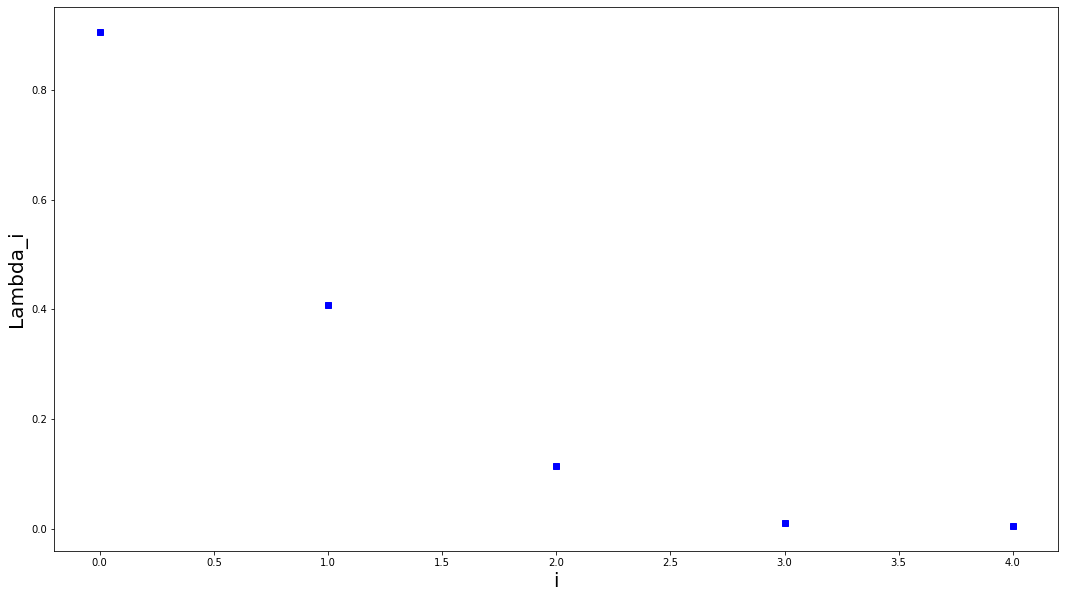

Sweep: 1 of 5, Energy: 0.097702, Bond dim: 5
Sweep: 2 of 5, Energy: 0.085459, Bond dim: 5
Sweep: 3 of 5, Energy: 0.076452, Bond dim: 5
Sweep: 4 of 5, Energy: 0.069278, Bond dim: 5
Sweep: 5 of 5, Energy: 0.063134, Bond dim: 5
CPU times: user 16.7 s, sys: 172 ms, total: 16.9 s
Wall time: 8.61 s
Minimal value of the functional:  0.06313422316976981

Entanglement entropy for different positions:

Position =  4 :  0.5468034258783501

Lambda_i = 0.9146348093197241
Lambda_i = 0.34670967747163645
Lambda_i = 0.20428264802483878
Lambda_i = 0.03665710659439196
Lambda_i = 0.012665756206131987


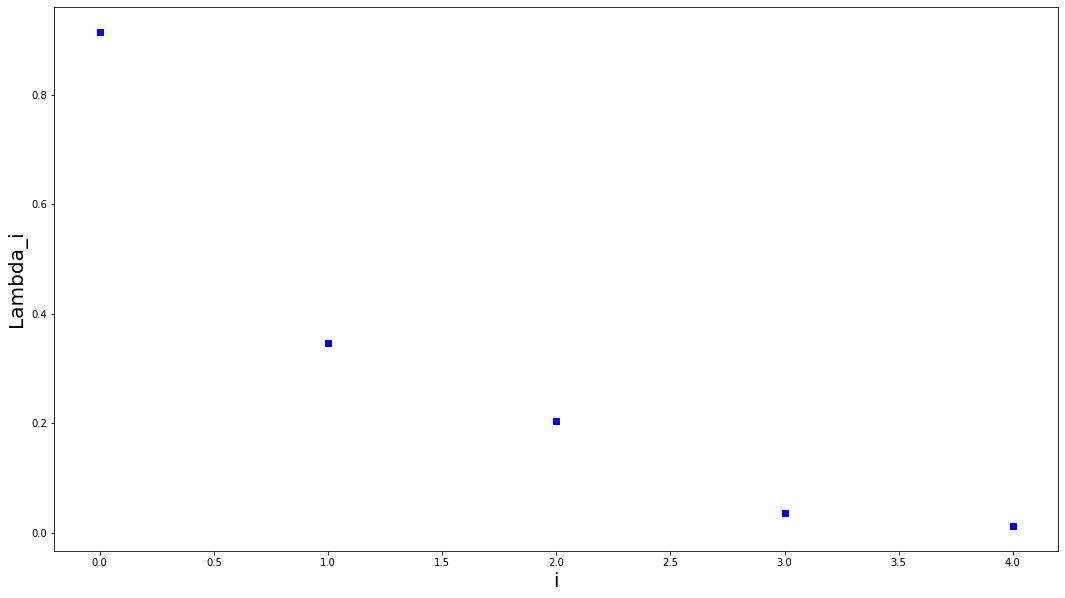

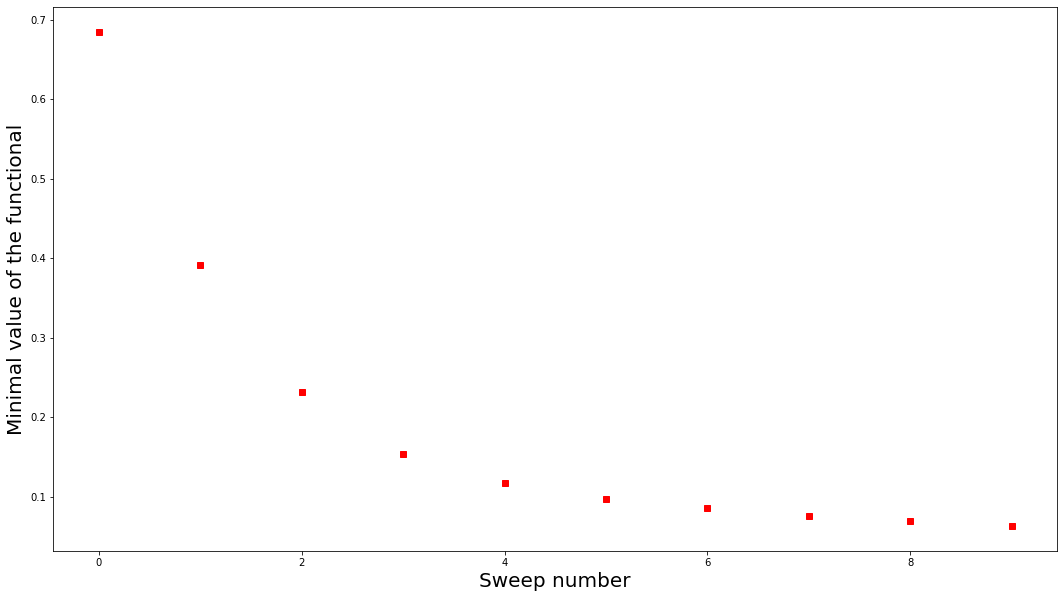

Sweep: 1 of 5, Energy: 0.053899, Bond dim: 15
Sweep: 2 of 5, Energy: 0.046827, Bond dim: 15
Sweep: 3 of 5, Energy: 0.041300, Bond dim: 15
Sweep: 4 of 5, Energy: 0.036882, Bond dim: 15
Sweep: 5 of 5, Energy: 0.033579, Bond dim: 15
CPU times: user 18.1 s, sys: 172 ms, total: 18.3 s
Wall time: 9.26 s

Entanglement entropy for different positions:

Position =  4 :  0.6302581239832947

Lambda_i = 0.9063639430969469
Lambda_i = 0.31105304865495254
Lambda_i = 0.26990848417315755
Lambda_i = 0.07361183533763076
Lambda_i = 0.04639703863229892
Lambda_i = 0.028135187857880706
Lambda_i = 0.01593421249806877
Lambda_i = 0.012607761925245249
Lambda_i = 0.008172583786121821
Lambda_i = 0.004310858559396352
Lambda_i = 0.003956973686303207
Lambda_i = 0.0032319550645010424
Lambda_i = 0.0025135201919914106
Lambda_i = 0.002061609522168509
Lambda_i = 0.0013917069786792305


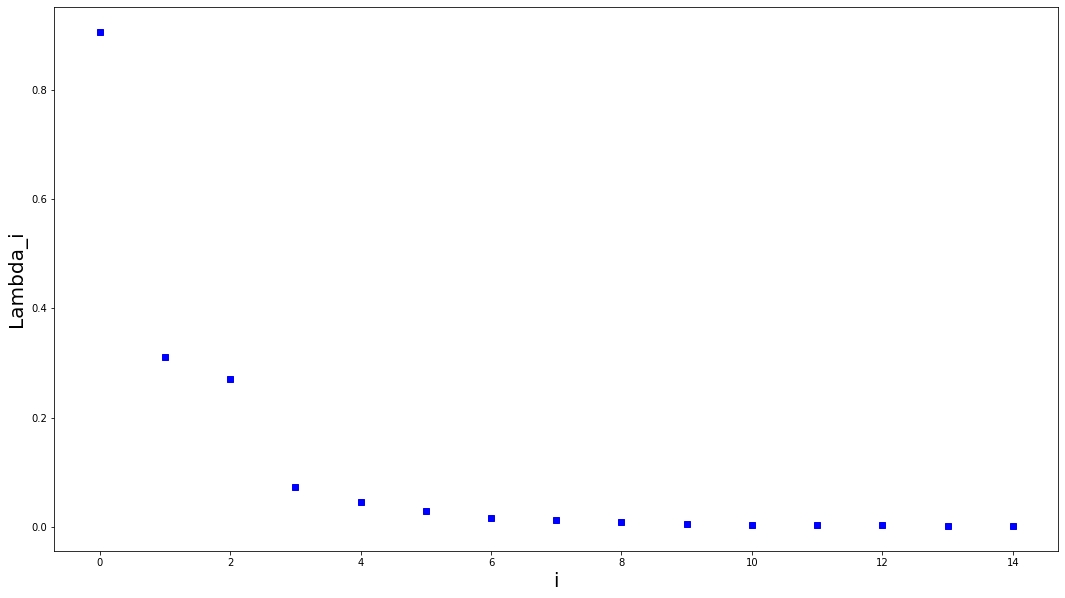

Sweep: 1 of 5, Energy: 0.030934, Bond dim: 15
Sweep: 2 of 5, Energy: 0.028969, Bond dim: 15
Sweep: 3 of 5, Energy: 0.027224, Bond dim: 15
Sweep: 4 of 5, Energy: 0.025720, Bond dim: 15
Sweep: 5 of 5, Energy: 0.024437, Bond dim: 15
CPU times: user 18.2 s, sys: 160 ms, total: 18.3 s
Wall time: 9.18 s
Minimal value of the functional:  0.024436782977754513

Entanglement entropy for different positions:

Position =  4 :  0.6698490820767782

Lambda_i = 0.898742385088514
Lambda_i = 0.30461247653996265
Lambda_i = 0.2958604759762124
Lambda_i = 0.09459946161974442
Lambda_i = 0.03907620989536763
Lambda_i = 0.02956309493432076
Lambda_i = 0.014080772425384752
Lambda_i = 0.013566323883395128
Lambda_i = 0.010884423108486712
Lambda_i = 0.005965830076103598
Lambda_i = 0.004779071211048909
Lambda_i = 0.0032808700931272893
Lambda_i = 0.002948574646825858
Lambda_i = 0.002481601974346789
Lambda_i = 0.0022643043920180426


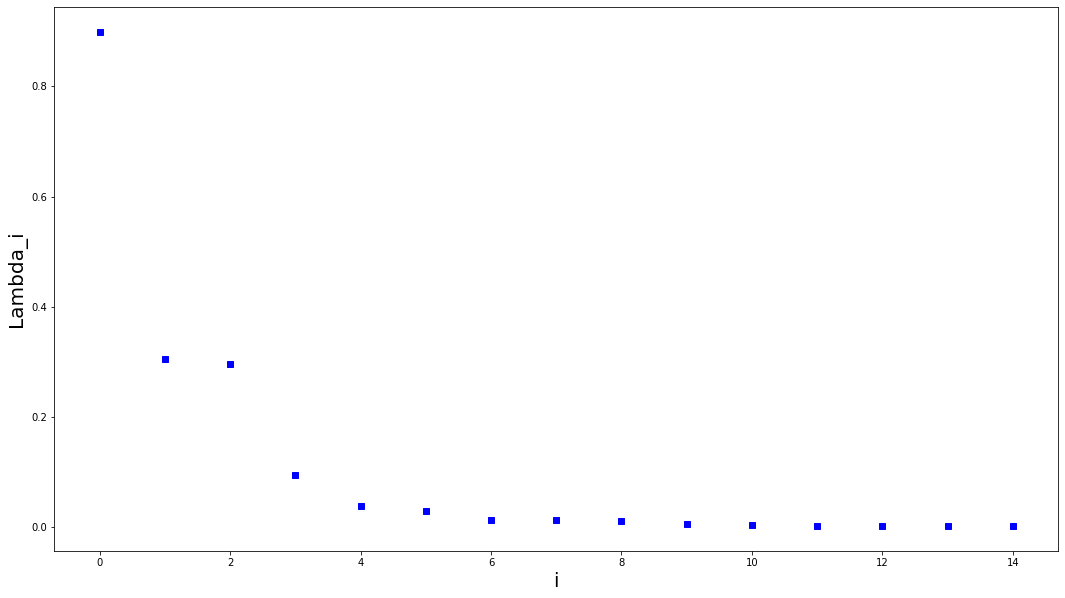

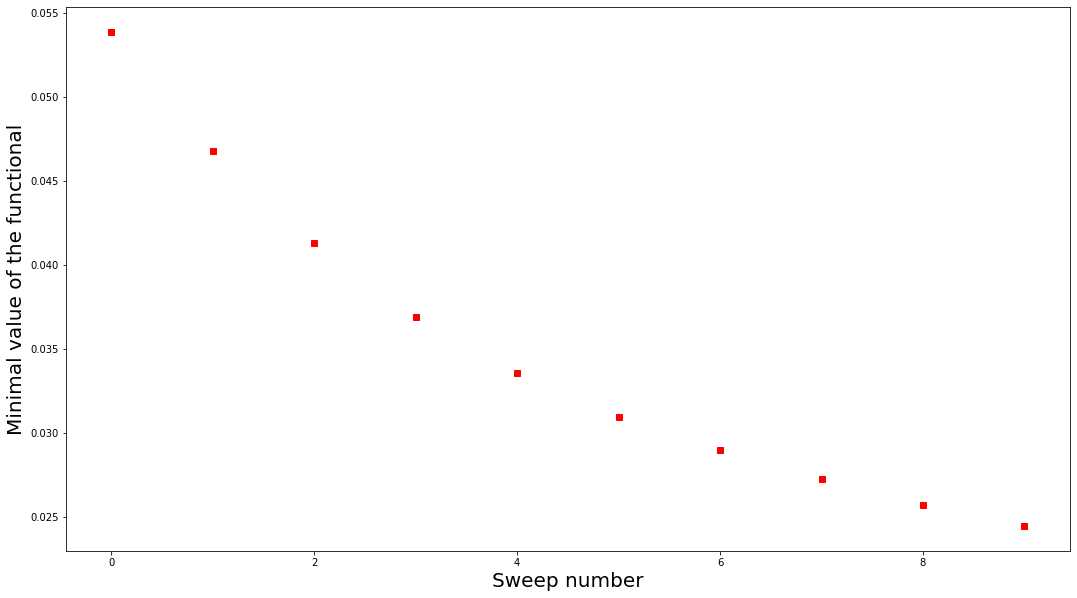

Sweep: 1 of 5, Energy: 0.022668, Bond dim: 25
Sweep: 2 of 5, Energy: 0.021542, Bond dim: 25
Sweep: 3 of 5, Energy: 0.020588, Bond dim: 25
Sweep: 4 of 5, Energy: 0.019775, Bond dim: 25
Sweep: 5 of 5, Energy: 0.019069, Bond dim: 25
CPU times: user 21 s, sys: 280 ms, total: 21.3 s
Wall time: 10.7 s

Entanglement entropy for different positions:

Position =  4 :  0.7072777592729538

Lambda_i = 0.8918313692366261
Lambda_i = 0.3200324226084099
Lambda_i = 0.29372624395897123
Lambda_i = 0.11230717763490636
Lambda_i = 0.033597574758202874
Lambda_i = 0.03080615806304633
Lambda_i = 0.021621075499922003
Lambda_i = 0.01488057852769252
Lambda_i = 0.011267007440373072
Lambda_i = 0.009181220823655516
Lambda_i = 0.008441951222225455
Lambda_i = 0.008194029955456912
Lambda_i = 0.00624099196749712
Lambda_i = 0.005682148271886964
Lambda_i = 0.005632958112451114
Lambda_i = 0.004903094070205838
Lambda_i = 0.004503562972606835
Lambda_i = 0.0043936780597733675
Lambda_i = 0.003883301156691369
Lambda_i = 0.00278

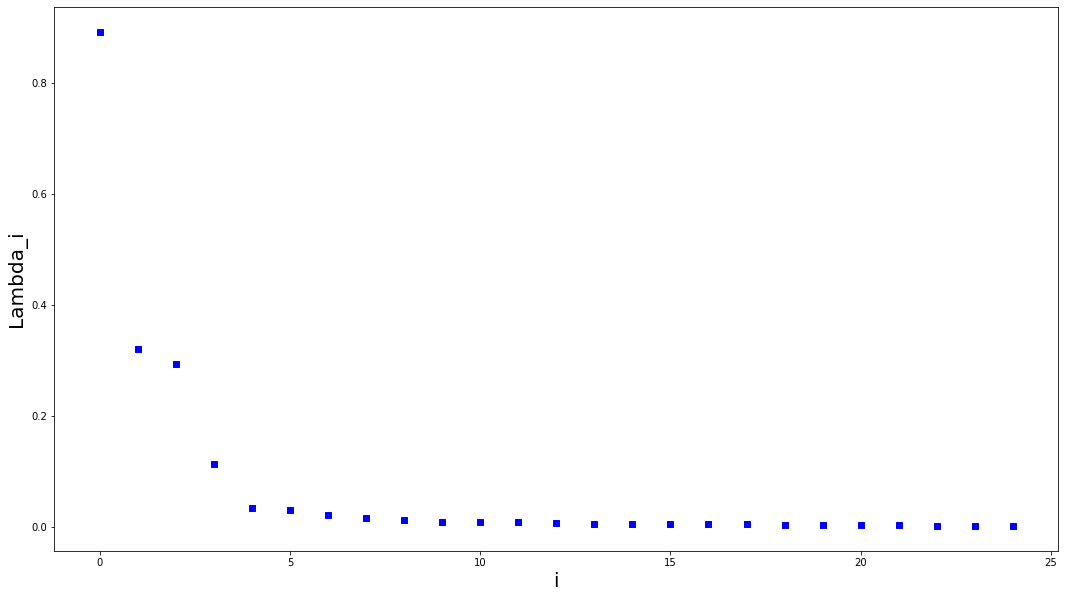

Sweep: 1 of 5, Energy: 0.018439, Bond dim: 25
Sweep: 2 of 5, Energy: 0.017885, Bond dim: 25
Sweep: 3 of 5, Energy: 0.017381, Bond dim: 25
Sweep: 4 of 5, Energy: 0.016940, Bond dim: 25
Sweep: 5 of 5, Energy: 0.016545, Bond dim: 25
CPU times: user 21.1 s, sys: 216 ms, total: 21.3 s
Wall time: 10.7 s
Minimal value of the functional:  0.016545185051513773

Entanglement entropy for different positions:

Position =  4 :  0.7321529289832641

Lambda_i = 0.8866898758115055
Lambda_i = 0.32984584443824
Lambda_i = 0.2934872113811895
Lambda_i = 0.12465680964758441
Lambda_i = 0.03015957141145849
Lambda_i = 0.027842966180387535
Lambda_i = 0.024875453183146285
Lambda_i = 0.01553743241704512
Lambda_i = 0.013269727915231226
Lambda_i = 0.010772707661261585
Lambda_i = 0.010030158973976992
Lambda_i = 0.007997321599048663
Lambda_i = 0.007098525091010054
Lambda_i = 0.006925398807097394
Lambda_i = 0.0067861526373762995
Lambda_i = 0.0056323388416831995
Lambda_i = 0.005508278565502232
Lambda_i = 0.0053495018358

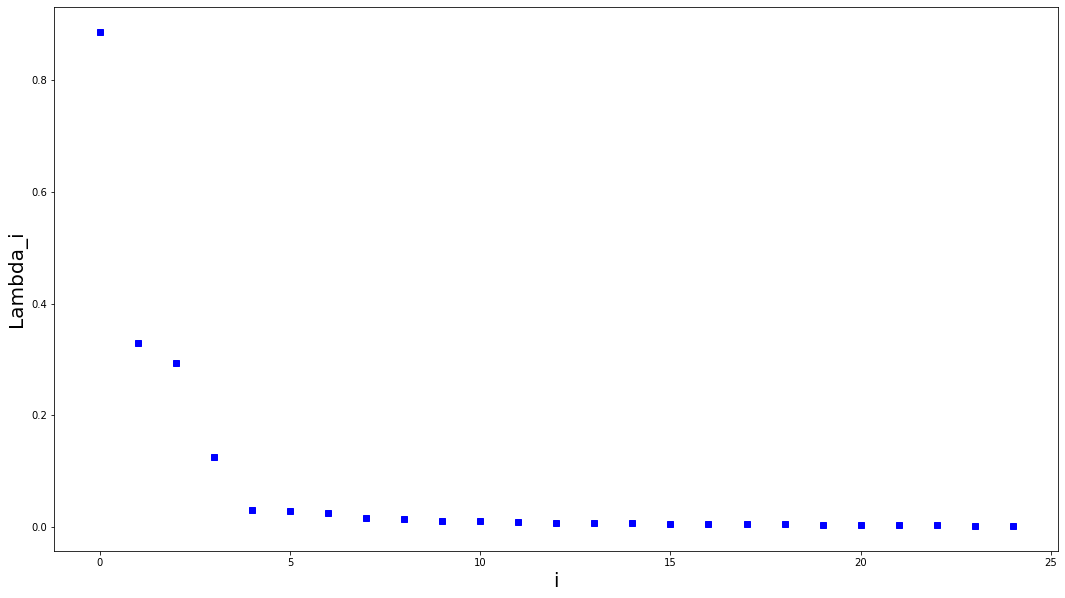

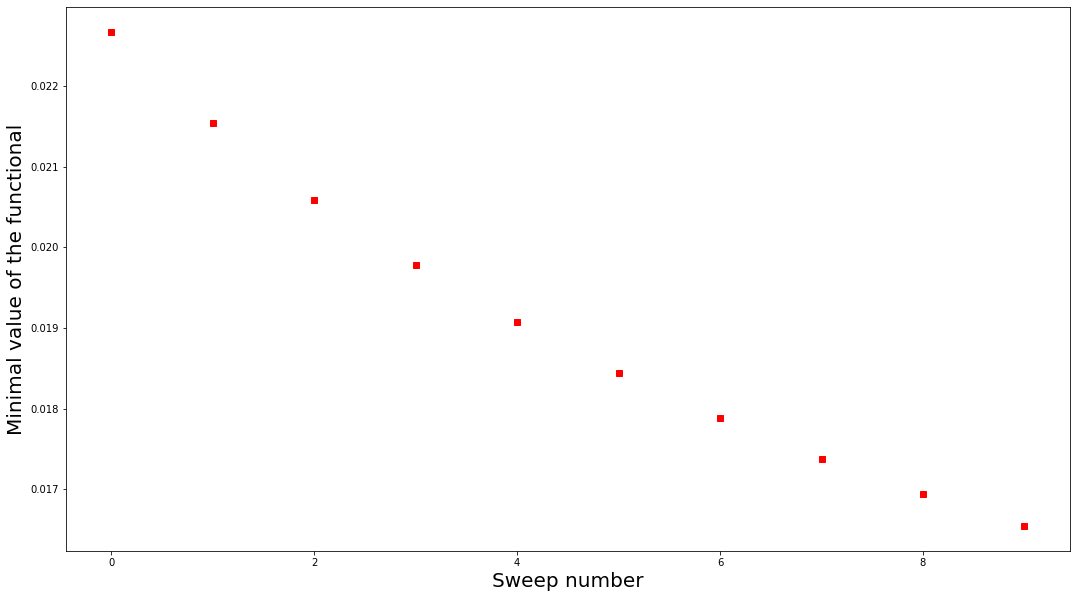

Sweep: 1 of 5, Energy: 0.015844, Bond dim: 35
Sweep: 2 of 5, Energy: 0.015430, Bond dim: 35
Sweep: 3 of 5, Energy: 0.015095, Bond dim: 35
Sweep: 4 of 5, Energy: 0.014774, Bond dim: 35
Sweep: 5 of 5, Energy: 0.014502, Bond dim: 35
CPU times: user 28.6 s, sys: 648 ms, total: 29.2 s
Wall time: 14.6 s

Entanglement entropy for different positions:

Position =  4 :  0.7591972299598757

Lambda_i = 0.8818556922343378
Lambda_i = 0.3364112322586987
Lambda_i = 0.29466386594387234
Lambda_i = 0.1352662794551571
Lambda_i = 0.031249777463468718
Lambda_i = 0.027766131838930844
Lambda_i = 0.025532671143161316
Lambda_i = 0.01791226017745451
Lambda_i = 0.017061056052358414
Lambda_i = 0.014344440733290244
Lambda_i = 0.012246310169869021
Lambda_i = 0.01008486195728175
Lambda_i = 0.009679330389050713
Lambda_i = 0.00863005208114135
Lambda_i = 0.008566199749723143
Lambda_i = 0.007749645392335377
Lambda_i = 0.007190358731730553
Lambda_i = 0.006538933999446828
Lambda_i = 0.006364706021047096
Lambda_i = 0.00594

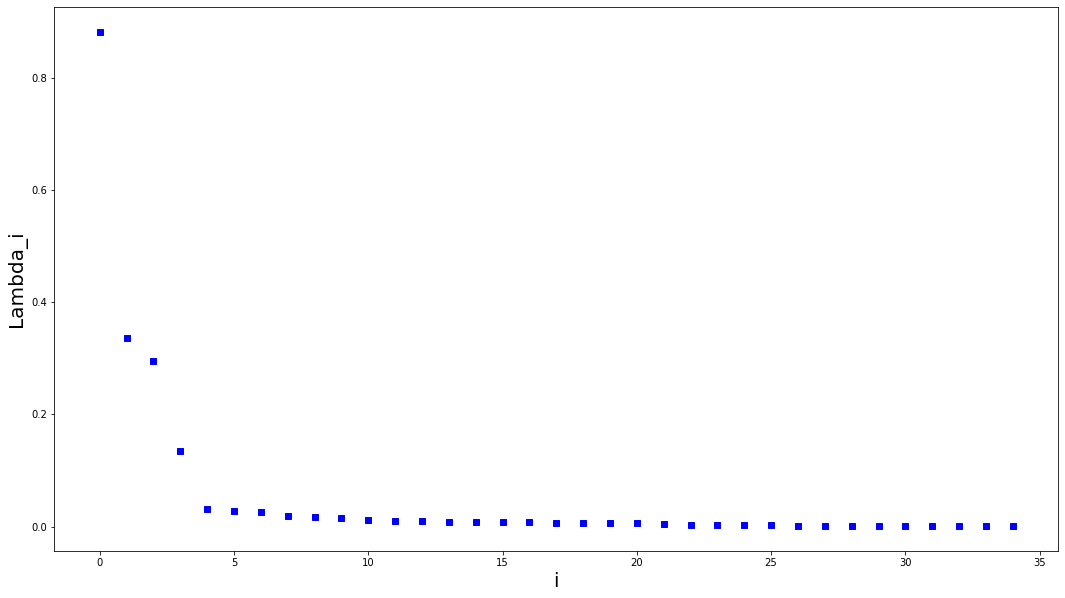

Sweep: 1 of 5, Energy: 0.014257, Bond dim: 35
Sweep: 2 of 5, Energy: 0.014032, Bond dim: 35
Sweep: 3 of 5, Energy: 0.013825, Bond dim: 35
Sweep: 4 of 5, Energy: 0.013632, Bond dim: 35
Sweep: 5 of 5, Energy: 0.013454, Bond dim: 35
CPU times: user 29.1 s, sys: 564 ms, total: 29.6 s
Wall time: 14.8 s
Minimal value of the functional:  0.0134538284590532

Entanglement entropy for different positions:

Position =  4 :  0.7755722216431792

Lambda_i = 0.8786161434360639
Lambda_i = 0.3403324524594846
Lambda_i = 0.29587295196652774
Lambda_i = 0.14284493809057724
Lambda_i = 0.03256878623326865
Lambda_i = 0.027546431525040854
Lambda_i = 0.02376441455197128
Lambda_i = 0.01890856919904532
Lambda_i = 0.01869458070178046
Lambda_i = 0.014899750700310915
Lambda_i = 0.013223303010497496
Lambda_i = 0.010908137803432884
Lambda_i = 0.010660477938510505
Lambda_i = 0.009405741404972185
Lambda_i = 0.008705566261578897
Lambda_i = 0.00824639630337841
Lambda_i = 0.007698110003828781
Lambda_i = 0.00736616005911637

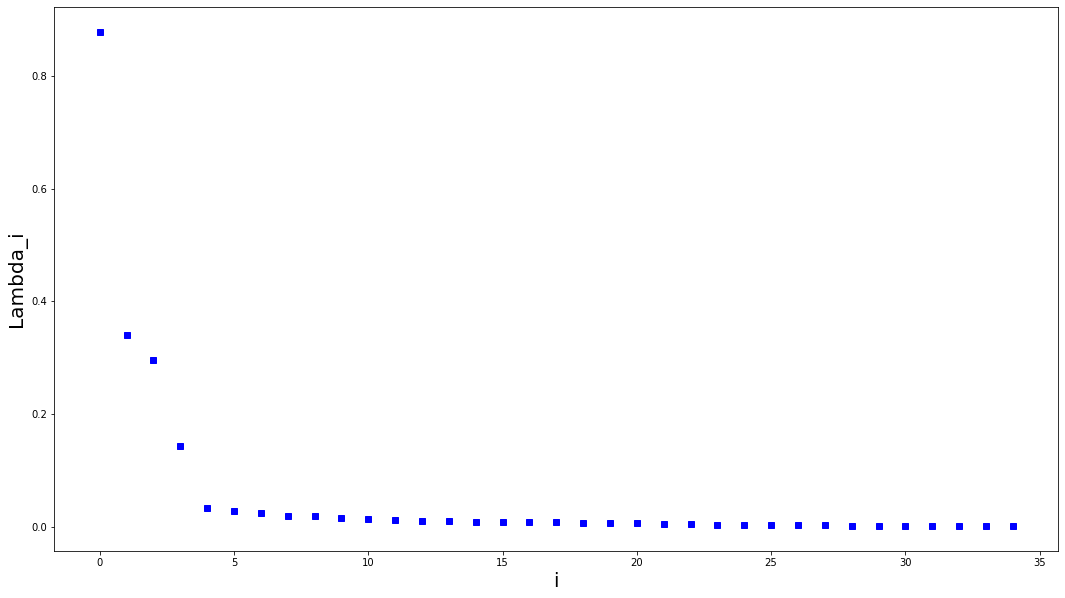

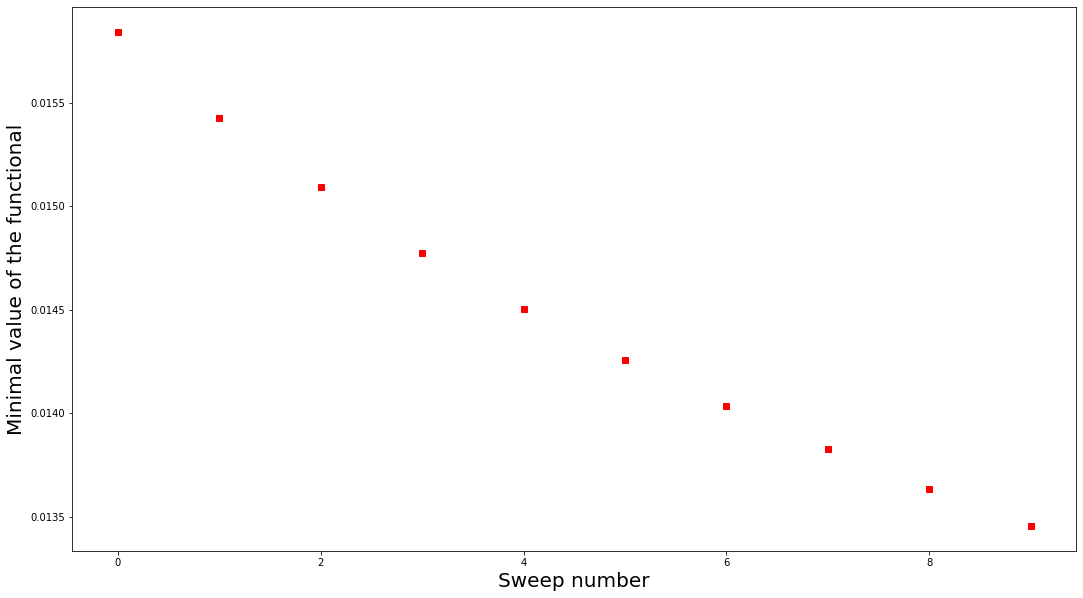

Sweep: 1 of 5, Energy: 0.013103, Bond dim: 45
Sweep: 2 of 5, Energy: 0.012913, Bond dim: 45
Sweep: 3 of 5, Energy: 0.012750, Bond dim: 45
Sweep: 4 of 5, Energy: 0.012604, Bond dim: 45
Sweep: 5 of 5, Energy: 0.012469, Bond dim: 45
CPU times: user 42.2 s, sys: 1.12 s, total: 43.3 s
Wall time: 21.7 s

Entanglement entropy for different positions:

Position =  4 :  0.7932538713671069

Lambda_i = 0.8756370571401859
Lambda_i = 0.3428138310248207
Lambda_i = 0.2974261853180157
Lambda_i = 0.14948694923453654
Lambda_i = 0.03469751326995008
Lambda_i = 0.02749999469657607
Lambda_i = 0.02385705794480143
Lambda_i = 0.02150849901967511
Lambda_i = 0.02043053059409322
Lambda_i = 0.015845273322766702
Lambda_i = 0.014965259220432615
Lambda_i = 0.012521941608779348
Lambda_i = 0.012260260241738347
Lambda_i = 0.011200544575378188
Lambda_i = 0.009518515296888188
Lambda_i = 0.009337349821981549
Lambda_i = 0.008663803785908863
Lambda_i = 0.008448440801626027
Lambda_i = 0.0077218291246287
Lambda_i = 0.007033639

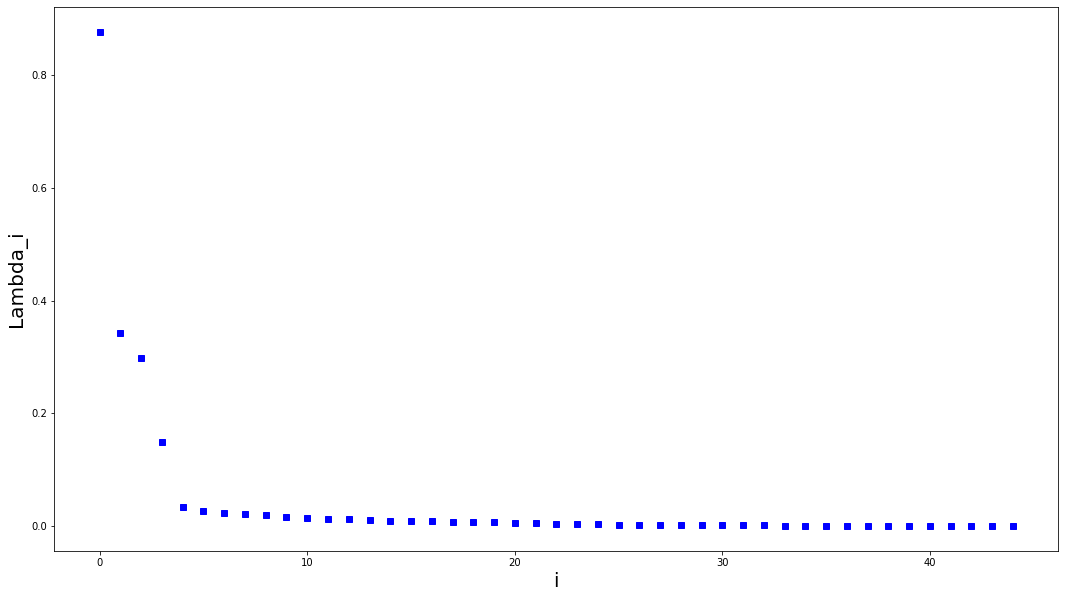

Sweep: 1 of 5, Energy: 0.012343, Bond dim: 45
Sweep: 2 of 5, Energy: 0.012226, Bond dim: 45
Sweep: 3 of 5, Energy: 0.012116, Bond dim: 45
Sweep: 4 of 5, Energy: 0.012014, Bond dim: 45
Sweep: 5 of 5, Energy: 0.011917, Bond dim: 45
CPU times: user 44.9 s, sys: 1.21 s, total: 46.2 s
Wall time: 23.1 s
Minimal value of the functional:  0.0119167183078341

Entanglement entropy for different positions:

Position =  4 :  0.8044277911018031

Lambda_i = 0.8734540903836169
Lambda_i = 0.34442594834386975
Lambda_i = 0.29894921534239516
Lambda_i = 0.15479587157986727
Lambda_i = 0.035604129077230706
Lambda_i = 0.02696775220426726
Lambda_i = 0.02393464710173454
Lambda_i = 0.022205730448191508
Lambda_i = 0.02107822173051302
Lambda_i = 0.015536598430992313
Lambda_i = 0.015412424737551916
Lambda_i = 0.013061890229079227
Lambda_i = 0.012848963542739244
Lambda_i = 0.011840919549182346
Lambda_i = 0.00994161352421081
Lambda_i = 0.009638559867715028
Lambda_i = 0.008900657824994558
Lambda_i = 0.008483617943412

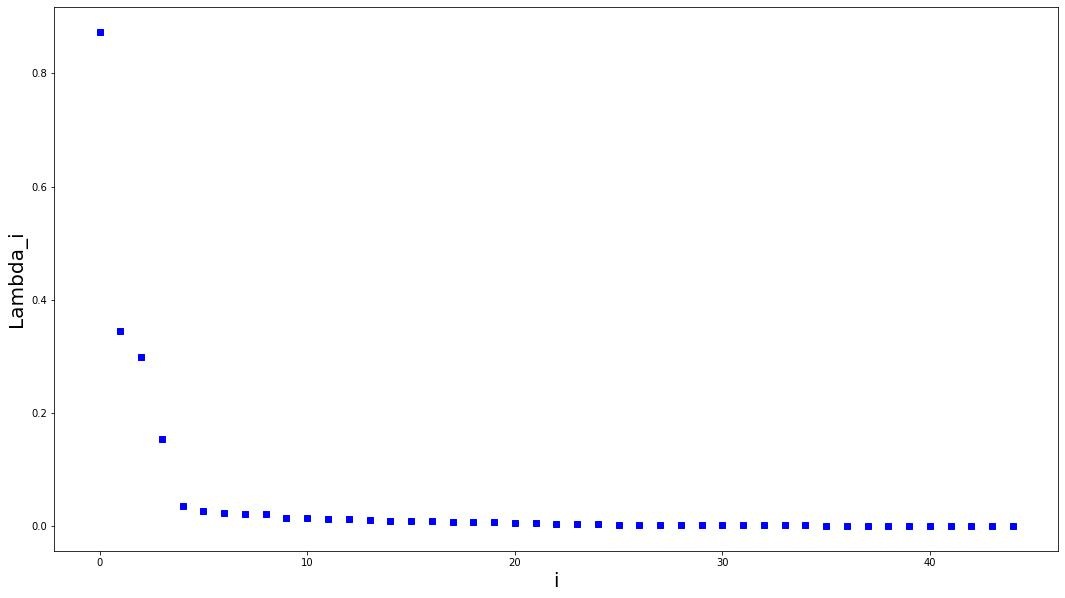

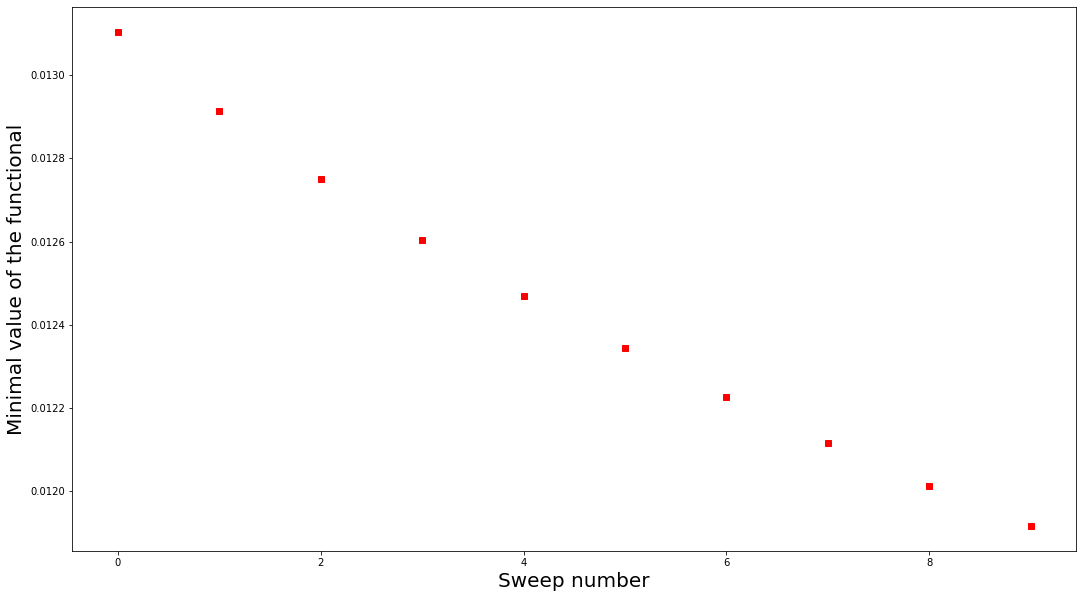

Sweep: 1 of 5, Energy: 0.011736, Bond dim: 55
Sweep: 2 of 5, Energy: 0.011625, Bond dim: 55
Sweep: 3 of 5, Energy: 0.011533, Bond dim: 55
Sweep: 4 of 5, Energy: 0.011447, Bond dim: 55
Sweep: 5 of 5, Energy: 0.011367, Bond dim: 55
CPU times: user 1min 3s, sys: 2.01 s, total: 1min 5s
Wall time: 33 s

Entanglement entropy for different positions:

Position =  4 :  0.8163006375753075

Lambda_i = 0.8714195015359819
Lambda_i = 0.3454524323613522
Lambda_i = 0.30046330876373695
Lambda_i = 0.1596183283350988
Lambda_i = 0.036601587267229896
Lambda_i = 0.02681417396704976
Lambda_i = 0.024818184835030857
Lambda_i = 0.023240598438681186
Lambda_i = 0.022168509291581505
Lambda_i = 0.016267798882117962
Lambda_i = 0.015653279097003227
Lambda_i = 0.013853134739433571
Lambda_i = 0.013723709385263601
Lambda_i = 0.012793790320986658
Lambda_i = 0.010866937181045118
Lambda_i = 0.010321397032287287
Lambda_i = 0.009279472918321159
Lambda_i = 0.008873972652357297
Lambda_i = 0.008696845588054239
Lambda_i = 0.007

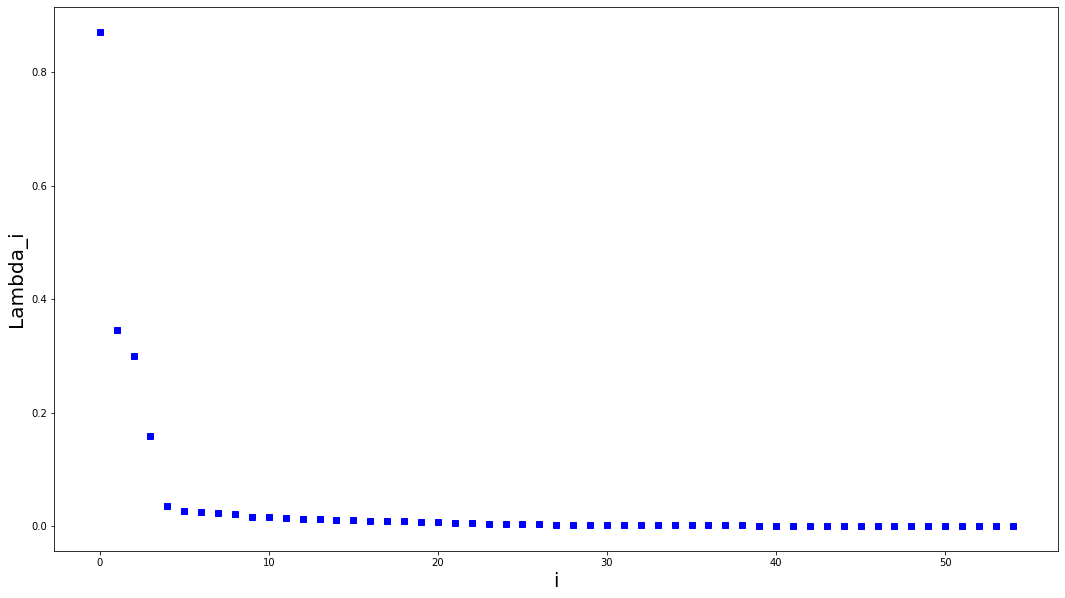

Sweep: 1 of 5, Energy: 0.011292, Bond dim: 55
Sweep: 2 of 5, Energy: 0.011221, Bond dim: 55
Sweep: 3 of 5, Energy: 0.011153, Bond dim: 55
Sweep: 4 of 5, Energy: 0.011089, Bond dim: 55
Sweep: 5 of 5, Energy: 0.011028, Bond dim: 55
CPU times: user 1min 4s, sys: 2.04 s, total: 1min 6s
Wall time: 33.5 s
Minimal value of the functional:  0.01102777817970224

Entanglement entropy for different positions:

Position =  4 :  0.8246914077524218

Lambda_i = 0.8697787940867537
Lambda_i = 0.34616361368625304
Lambda_i = 0.3019847062377472
Lambda_i = 0.16365384772609617
Lambda_i = 0.03702996123829443
Lambda_i = 0.026436295974250037
Lambda_i = 0.025301689249401224
Lambda_i = 0.023575699862682035
Lambda_i = 0.022709518838927776
Lambda_i = 0.01656206297541592
Lambda_i = 0.015484286366109268
Lambda_i = 0.014091176548615273
Lambda_i = 0.014045936196198629
Lambda_i = 0.013168203370572115
Lambda_i = 0.011294388943785635
Lambda_i = 0.01055114810185699
Lambda_i = 0.00936274193066977
Lambda_i = 0.0089488923715

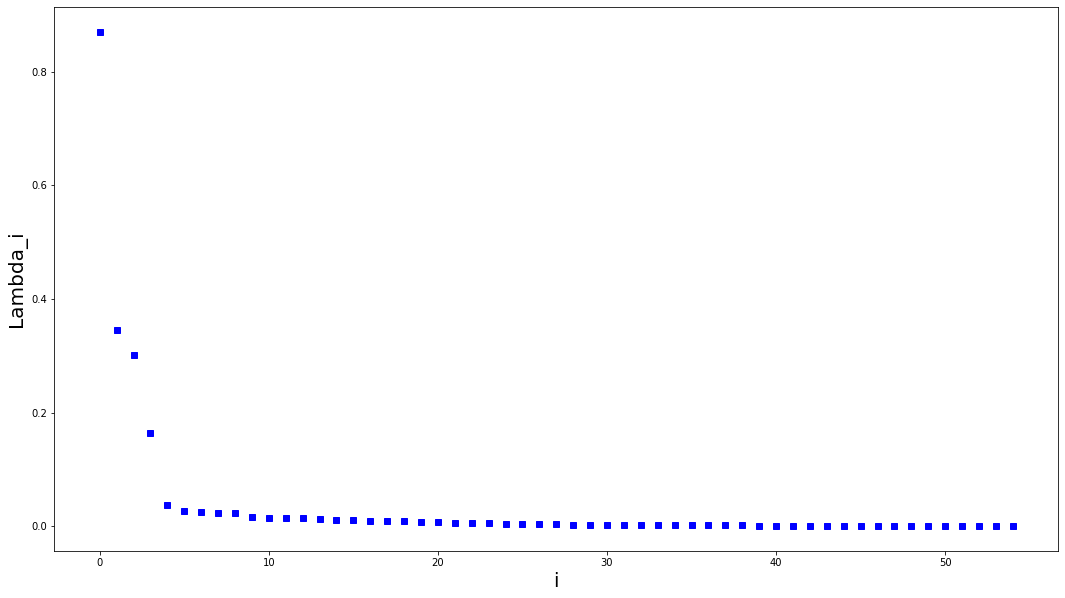

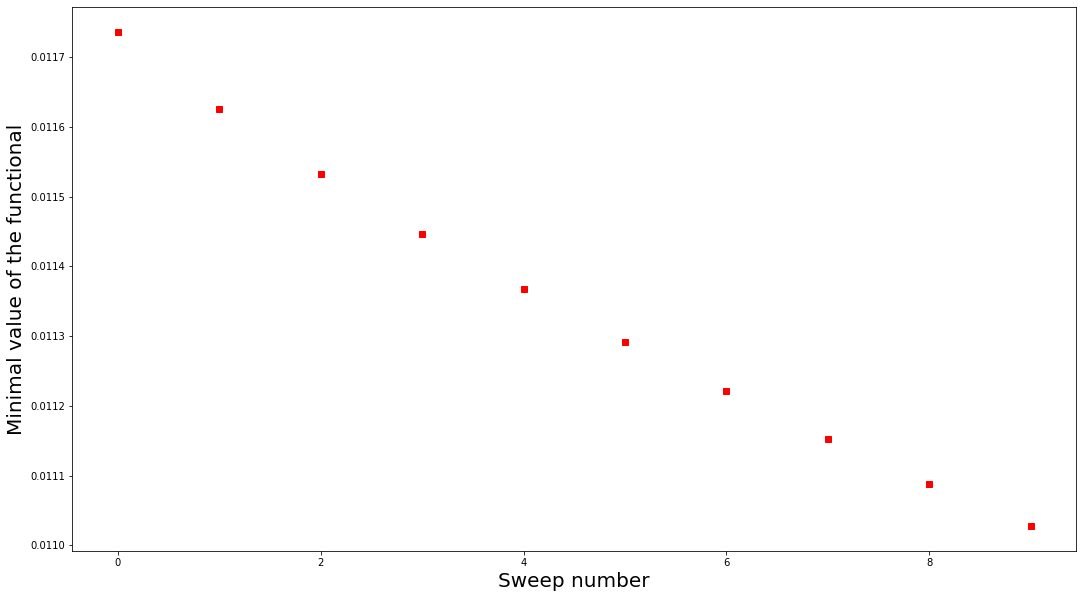

Sweep: 1 of 5, Energy: 0.010921, Bond dim: 65
Sweep: 2 of 5, Energy: 0.010854, Bond dim: 65
Sweep: 3 of 5, Energy: 0.010791, Bond dim: 65
Sweep: 4 of 5, Energy: 0.010732, Bond dim: 65
Sweep: 5 of 5, Energy: 0.010675, Bond dim: 65
CPU times: user 1min 35s, sys: 3.74 s, total: 1min 39s
Wall time: 51.4 s

Entanglement entropy for different positions:

Position =  4 :  0.8341940929861489

Lambda_i = 0.8680707911269081
Lambda_i = 0.34666200106304285
Lambda_i = 0.3036522792593584
Lambda_i = 0.1676426169533865
Lambda_i = 0.03763077098968065
Lambda_i = 0.02628630475811515
Lambda_i = 0.026078674389742283
Lambda_i = 0.02420886528496749
Lambda_i = 0.023520910242070633
Lambda_i = 0.01709186235654519
Lambda_i = 0.015731061678257736
Lambda_i = 0.014638137126293131
Lambda_i = 0.01432741833590984
Lambda_i = 0.013687811055166105
Lambda_i = 0.011878975288720856
Lambda_i = 0.01098716460700527
Lambda_i = 0.00955635027039607
Lambda_i = 0.009378123077081253
Lambda_i = 0.009224988288623504
Lambda_i = 0.00776

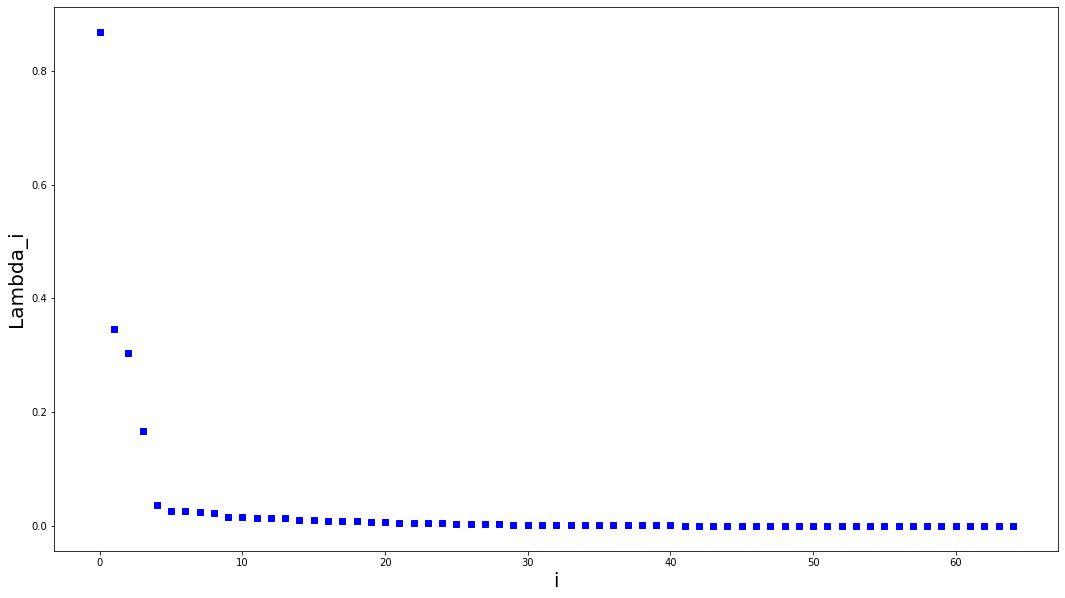

Sweep: 1 of 5, Energy: 0.010621, Bond dim: 65
Sweep: 2 of 5, Energy: 0.010570, Bond dim: 65
Sweep: 3 of 5, Energy: 0.010521, Bond dim: 65
Sweep: 4 of 5, Energy: 0.010475, Bond dim: 65
Sweep: 5 of 5, Energy: 0.010431, Bond dim: 65
CPU times: user 1min 38s, sys: 3.63 s, total: 1min 41s
Wall time: 52.8 s
Minimal value of the functional:  0.010430865431514951

Entanglement entropy for different positions:

Position =  4 :  0.8417270432657906

Lambda_i = 0.8665651538713087
Lambda_i = 0.3469744534191652
Lambda_i = 0.30536499615882445
Lambda_i = 0.17128524751205682
Lambda_i = 0.03785091042006407
Lambda_i = 0.026541351008736225
Lambda_i = 0.02602646674643102
Lambda_i = 0.024534057326057047
Lambda_i = 0.023986405663760316
Lambda_i = 0.017319360700313296
Lambda_i = 0.01589929803645907
Lambda_i = 0.01489237741843084
Lambda_i = 0.014377376667558664
Lambda_i = 0.013684549088113559
Lambda_i = 0.012187850537072095
Lambda_i = 0.01114707689481147
Lambda_i = 0.009584286506877782
Lambda_i = 0.00956234559

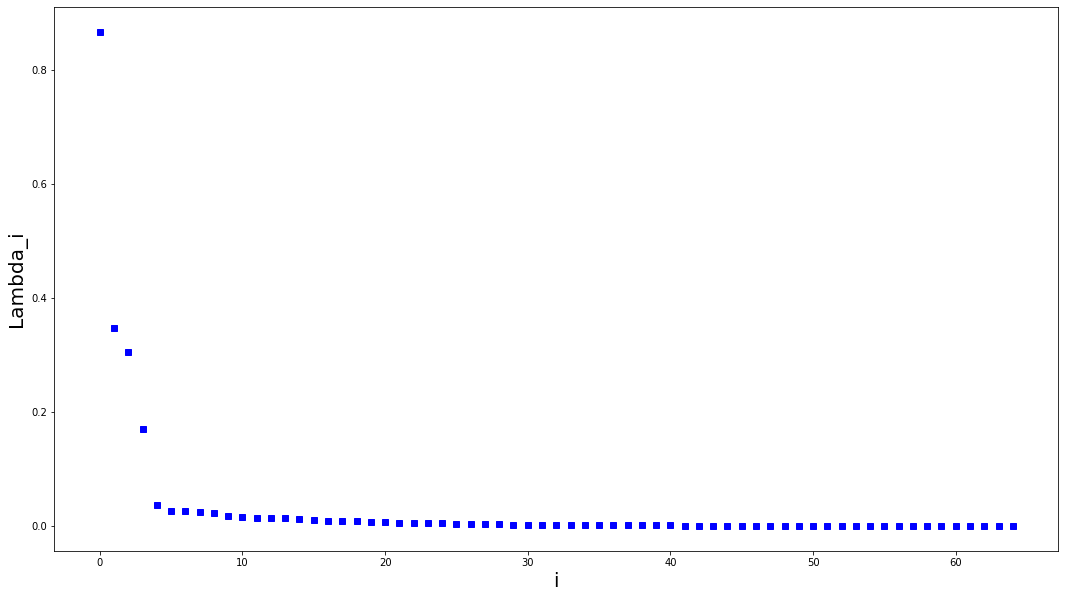

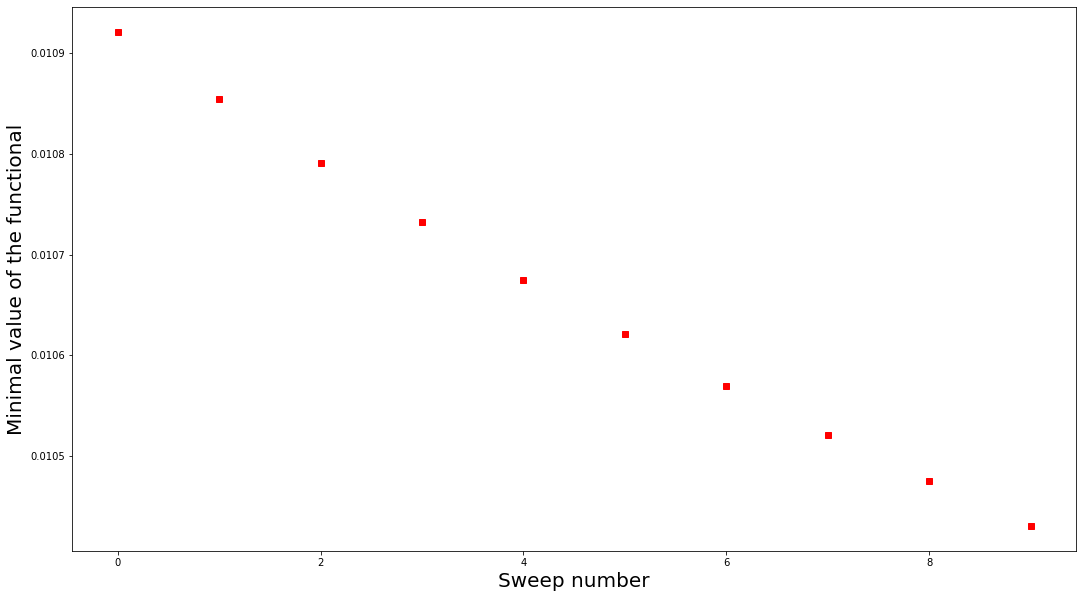

Sweep: 1 of 5, Energy: 0.010363, Bond dim: 75
Sweep: 2 of 5, Energy: 0.010318, Bond dim: 75
Sweep: 3 of 5, Energy: 0.010277, Bond dim: 75
Sweep: 4 of 5, Energy: 0.010238, Bond dim: 75
Sweep: 5 of 5, Energy: 0.010200, Bond dim: 75
CPU times: user 2min 3s, sys: 5.3 s, total: 2min 8s
Wall time: 1min 12s

Entanglement entropy for different positions:

Position =  4 :  0.8493160716715531

Lambda_i = 0.8651295720642599
Lambda_i = 0.34708587049153083
Lambda_i = 0.3070981055034904
Lambda_i = 0.17464560607635277
Lambda_i = 0.03809211509003447
Lambda_i = 0.02706784388746592
Lambda_i = 0.02593906471313419
Lambda_i = 0.024998529925796622
Lambda_i = 0.024520601193923946
Lambda_i = 0.017672873394726014
Lambda_i = 0.01624678769374539
Lambda_i = 0.015227471362782945
Lambda_i = 0.01467134659413896
Lambda_i = 0.013513931787348036
Lambda_i = 0.012587233640751795
Lambda_i = 0.011384908027955689
Lambda_i = 0.009830770468108905
Lambda_i = 0.00969909892735029
Lambda_i = 0.00947442503487867
Lambda_i = 0.00811

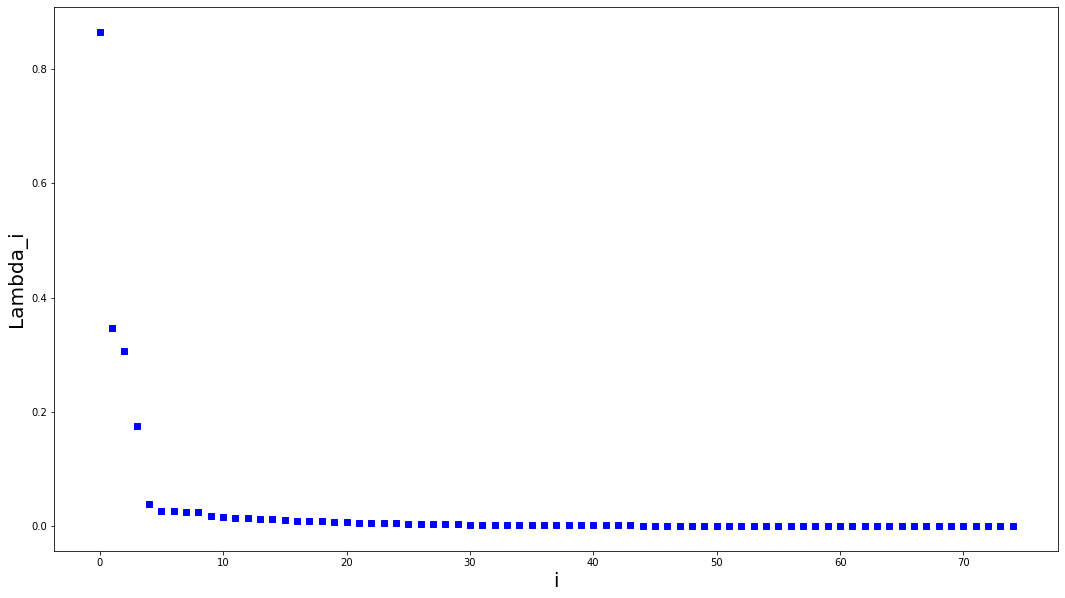

Sweep: 1 of 5, Energy: 0.010164, Bond dim: 75
Sweep: 2 of 5, Energy: 0.010128, Bond dim: 75
Sweep: 3 of 5, Energy: 0.010095, Bond dim: 75
Sweep: 4 of 5, Energy: 0.010063, Bond dim: 75
Sweep: 5 of 5, Energy: 0.010032, Bond dim: 75
CPU times: user 2min 1s, sys: 5.06 s, total: 2min 6s
Wall time: 1min 11s
Minimal value of the functional:  0.010032391489137649

Entanglement entropy for different positions:

Position =  4 :  0.8556180831755306

Lambda_i = 0.8638608947586759
Lambda_i = 0.34698059583801105
Lambda_i = 0.3088414866369696
Lambda_i = 0.1777713297671987
Lambda_i = 0.03817000903407564
Lambda_i = 0.027400964261846794
Lambda_i = 0.025868242451343212
Lambda_i = 0.02530699388467699
Lambda_i = 0.02480431154009197
Lambda_i = 0.017869723597867183
Lambda_i = 0.016460410781265228
Lambda_i = 0.015399532773941566
Lambda_i = 0.014872840324197046
Lambda_i = 0.013214489520249529
Lambda_i = 0.012828262859676736
Lambda_i = 0.011497928868398162
Lambda_i = 0.009979387796943177
Lambda_i = 0.0097514524

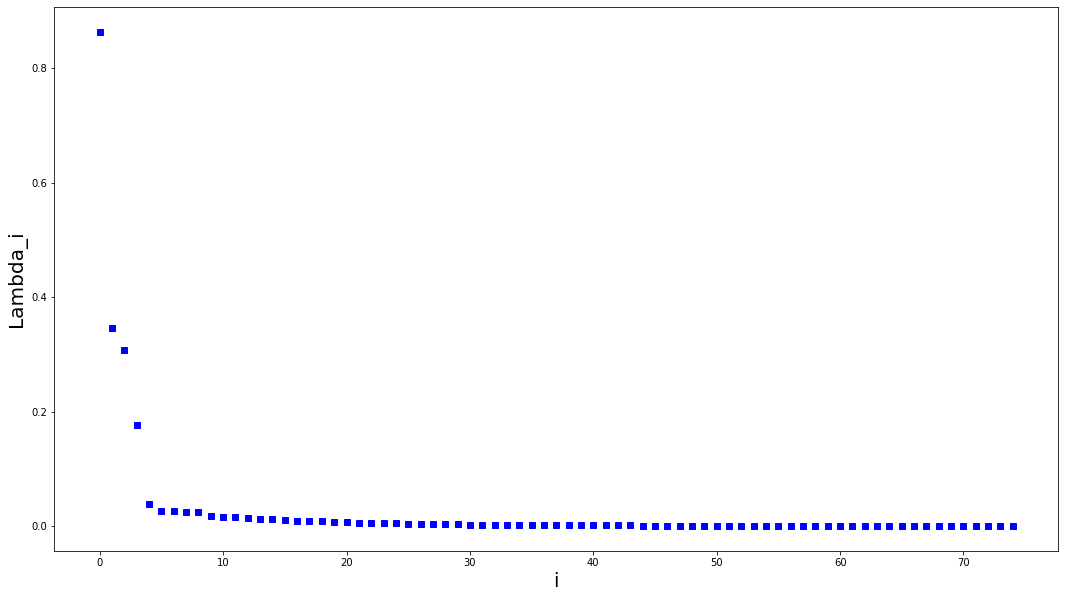

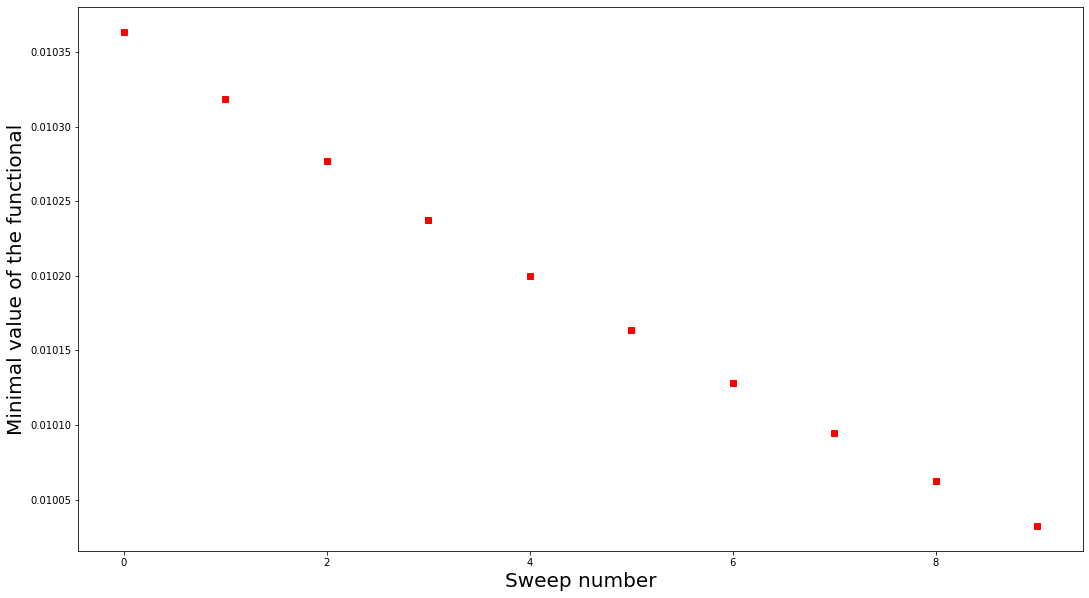

Sweep: 1 of 5, Energy: 0.009986, Bond dim: 85
Sweep: 2 of 5, Energy: 0.009954, Bond dim: 85
Sweep: 3 of 5, Energy: 0.009925, Bond dim: 85
Sweep: 4 of 5, Energy: 0.009898, Bond dim: 85
Sweep: 5 of 5, Energy: 0.009871, Bond dim: 85
CPU times: user 2min 34s, sys: 7.69 s, total: 2min 41s
Wall time: 1min 38s

Entanglement entropy for different positions:

Position =  4 :  0.8619023714895484

Lambda_i = 0.8626607840097714
Lambda_i = 0.3467908849105338
Lambda_i = 0.3105099687756558
Lambda_i = 0.18063196931767728
Lambda_i = 0.03830144530774362
Lambda_i = 0.02777705904945038
Lambda_i = 0.026034368132791294
Lambda_i = 0.025700383218885514
Lambda_i = 0.02498499145157994
Lambda_i = 0.018124549799795452
Lambda_i = 0.016751604479612235
Lambda_i = 0.015632078468962272
Lambda_i = 0.015150081174016885
Lambda_i = 0.013107484169331132
Lambda_i = 0.01303736899071693
Lambda_i = 0.011689320014262062
Lambda_i = 0.010184360214983689
Lambda_i = 0.009895558985529539
Lambda_i = 0.009569465131575763
Lambda_i = 0.

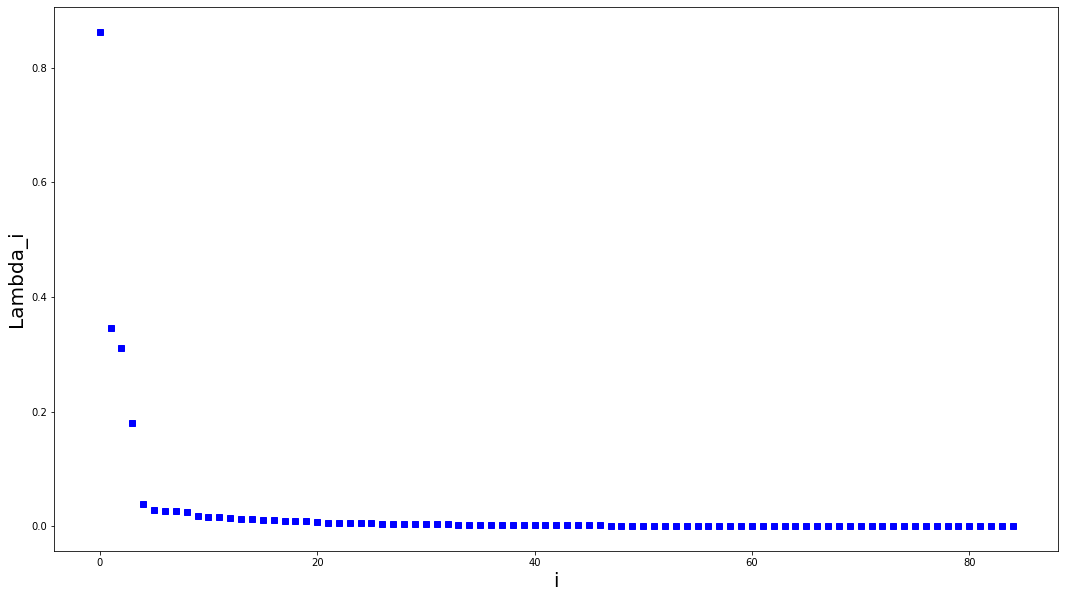

Sweep: 1 of 5, Energy: 0.009846, Bond dim: 85
Sweep: 2 of 5, Energy: 0.009822, Bond dim: 85
Sweep: 3 of 5, Energy: 0.009798, Bond dim: 85
Sweep: 4 of 5, Energy: 0.009776, Bond dim: 85
Sweep: 5 of 5, Energy: 0.009754, Bond dim: 85
CPU times: user 2min 38s, sys: 7.44 s, total: 2min 45s
Wall time: 1min 40s
Minimal value of the functional:  0.009753994208567854

Entanglement entropy for different positions:

Position =  4 :  0.8671675610355613

Lambda_i = 0.8615867374091423
Lambda_i = 0.3465603466171227
Lambda_i = 0.3120973249406285
Lambda_i = 0.18323790311361396
Lambda_i = 0.03832334384100937
Lambda_i = 0.028034348729478954
Lambda_i = 0.026259473389354214
Lambda_i = 0.02595405145031953
Lambda_i = 0.02495577068685926
Lambda_i = 0.018264043578586697
Lambda_i = 0.016948288168344233
Lambda_i = 0.015754755608672257
Lambda_i = 0.015311414886478417
Lambda_i = 0.013274692147155744
Lambda_i = 0.012843087550287062
Lambda_i = 0.011778542245879788
Lambda_i = 0.010292999821942206
Lambda_i = 0.00998623

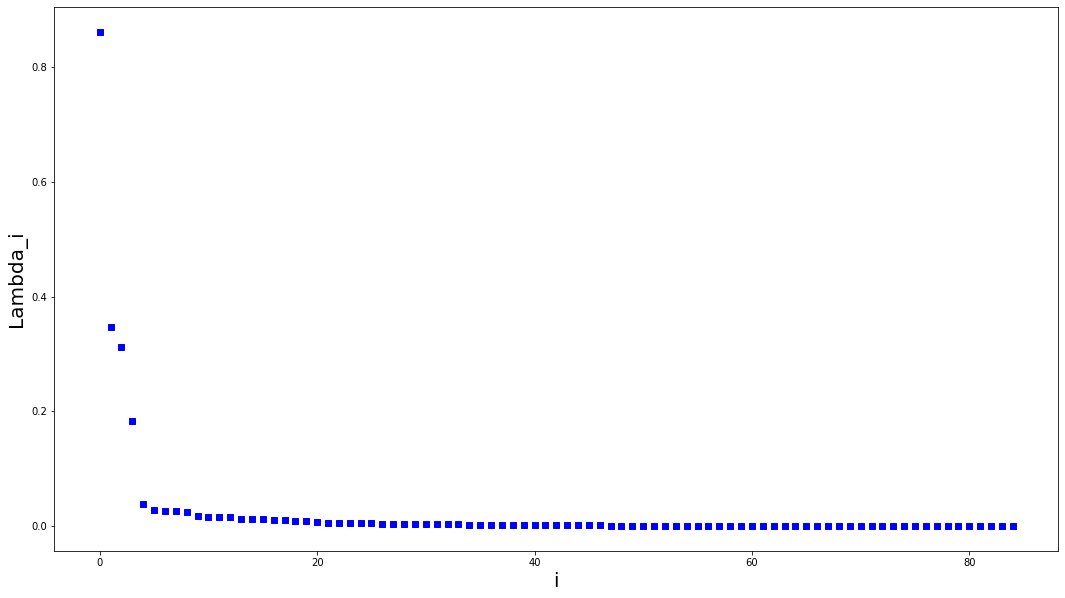

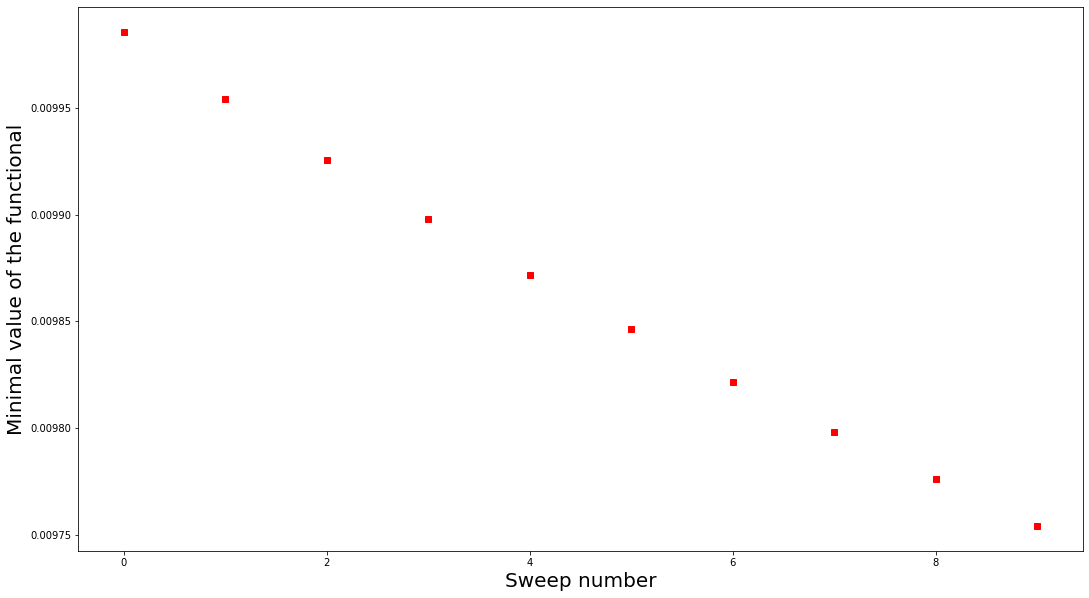

Sweep: 1 of 5, Energy: 0.009721, Bond dim: 95
Sweep: 2 of 5, Energy: 0.009699, Bond dim: 95
Sweep: 3 of 5, Energy: 0.009677, Bond dim: 95
Sweep: 4 of 5, Energy: 0.009657, Bond dim: 95
Sweep: 5 of 5, Energy: 0.009638, Bond dim: 95
CPU times: user 3min 8s, sys: 9.73 s, total: 3min 18s
Wall time: 2min 6s

Entanglement entropy for different positions:

Position =  4 :  0.8725418452795484

Lambda_i = 0.8605291880591757
Lambda_i = 0.3463117073667523
Lambda_i = 0.313647684063413
Lambda_i = 0.18570447471746887
Lambda_i = 0.038380193713262074
Lambda_i = 0.028343955810753864
Lambda_i = 0.026584522733077254
Lambda_i = 0.026263378836056707
Lambda_i = 0.024933761391745045
Lambda_i = 0.018452724460575255
Lambda_i = 0.017190355857708357
Lambda_i = 0.015909145226678092
Lambda_i = 0.015513567122032675
Lambda_i = 0.013500326507973776
Lambda_i = 0.012731995409224062
Lambda_i = 0.011908863869946735
Lambda_i = 0.010452889682331974
Lambda_i = 0.01011339527254161
Lambda_i = 0.009575432948903872
Lambda_i = 0.

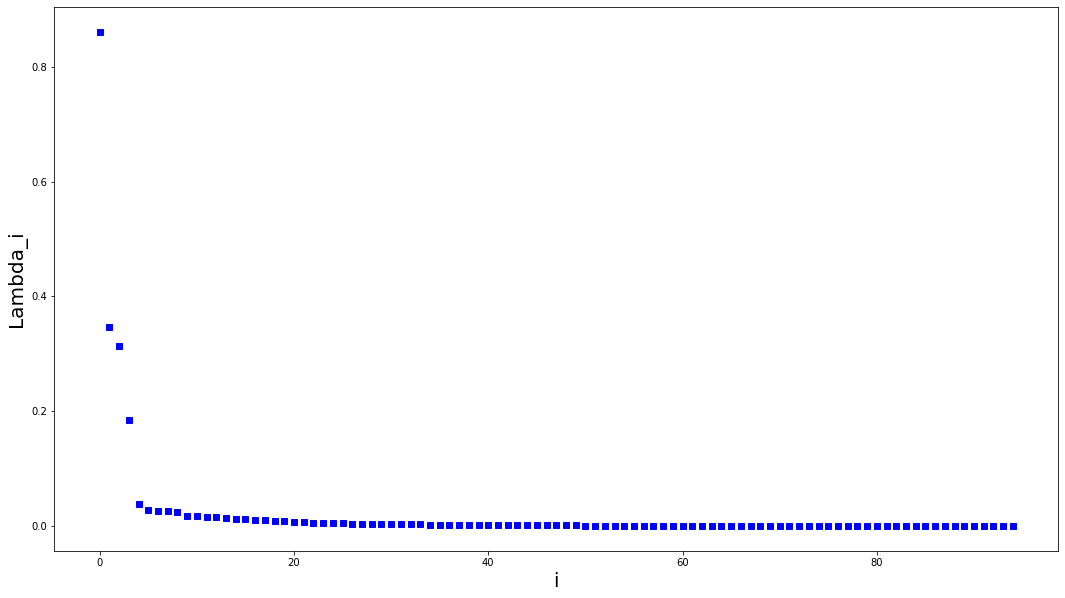

Sweep: 1 of 5, Energy: 0.009620, Bond dim: 95
Sweep: 2 of 5, Energy: 0.009602, Bond dim: 95
Sweep: 3 of 5, Energy: 0.009585, Bond dim: 95
Sweep: 4 of 5, Energy: 0.009569, Bond dim: 95
Sweep: 5 of 5, Energy: 0.009553, Bond dim: 95
CPU times: user 3min 13s, sys: 10.1 s, total: 3min 23s
Wall time: 2min 10s
Minimal value of the functional:  0.009552980109844815

Entanglement entropy for different positions:

Position =  4 :  0.8771515046018561

Lambda_i = 0.8595715690261536
Lambda_i = 0.3460240106843554
Lambda_i = 0.31513288762607694
Lambda_i = 0.18797452365737433
Lambda_i = 0.03837458764778621
Lambda_i = 0.02856937872072097
Lambda_i = 0.026856160279377414
Lambda_i = 0.026479178632318492
Lambda_i = 0.02485435628785184
Lambda_i = 0.01856600261847205
Lambda_i = 0.017358109130039066
Lambda_i = 0.015990443338263046
Lambda_i = 0.01564130131110496
Lambda_i = 0.013638486191051277
Lambda_i = 0.01263145983756558
Lambda_i = 0.01196297246293817
Lambda_i = 0.010539606198435263
Lambda_i = 0.01019997032

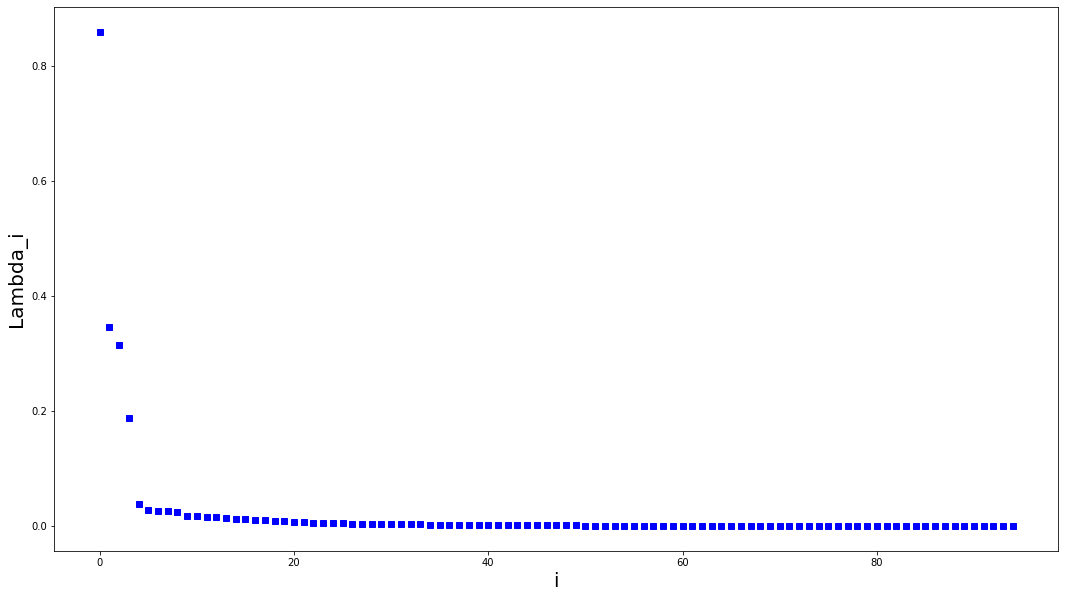

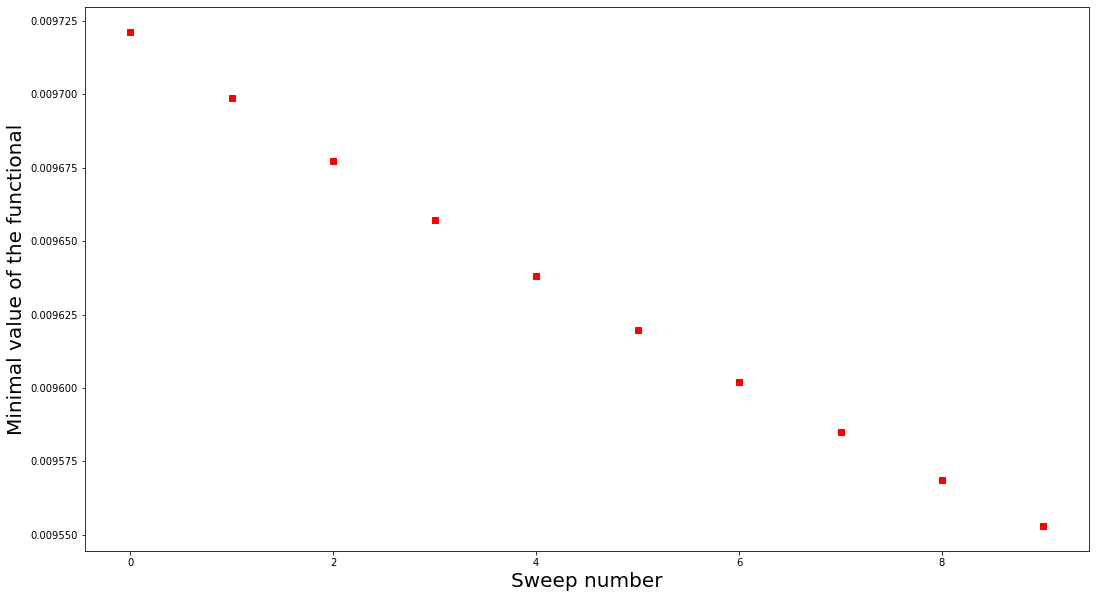

Sweep: 1 of 5, Energy: 0.009529, Bond dim: 105
Sweep: 2 of 5, Energy: 0.009513, Bond dim: 105
Sweep: 3 of 5, Energy: 0.009499, Bond dim: 105
Sweep: 4 of 5, Energy: 0.009485, Bond dim: 105
Sweep: 5 of 5, Energy: 0.009471, Bond dim: 105
CPU times: user 3min 58s, sys: 13.7 s, total: 4min 12s
Wall time: 2min 49s

Entanglement entropy for different positions:

Position =  4 :  0.8816202988223831

Lambda_i = 0.8586745881352841
Lambda_i = 0.3457313727663231
Lambda_i = 0.31651452303970906
Lambda_i = 0.1900431903263368
Lambda_i = 0.03839480211574362
Lambda_i = 0.02881789378701566
Lambda_i = 0.027153808494648518
Lambda_i = 0.026715743595601738
Lambda_i = 0.024808840436527892
Lambda_i = 0.01869748672399982
Lambda_i = 0.017556922871068206
Lambda_i = 0.016091261081610853
Lambda_i = 0.0157970537189533
Lambda_i = 0.01380446649186177
Lambda_i = 0.012615999846643442
Lambda_i = 0.01202017973297809
Lambda_i = 0.010652063637087598
Lambda_i = 0.010322036797841477
Lambda_i = 0.009565284768162116
Lambda_i = 

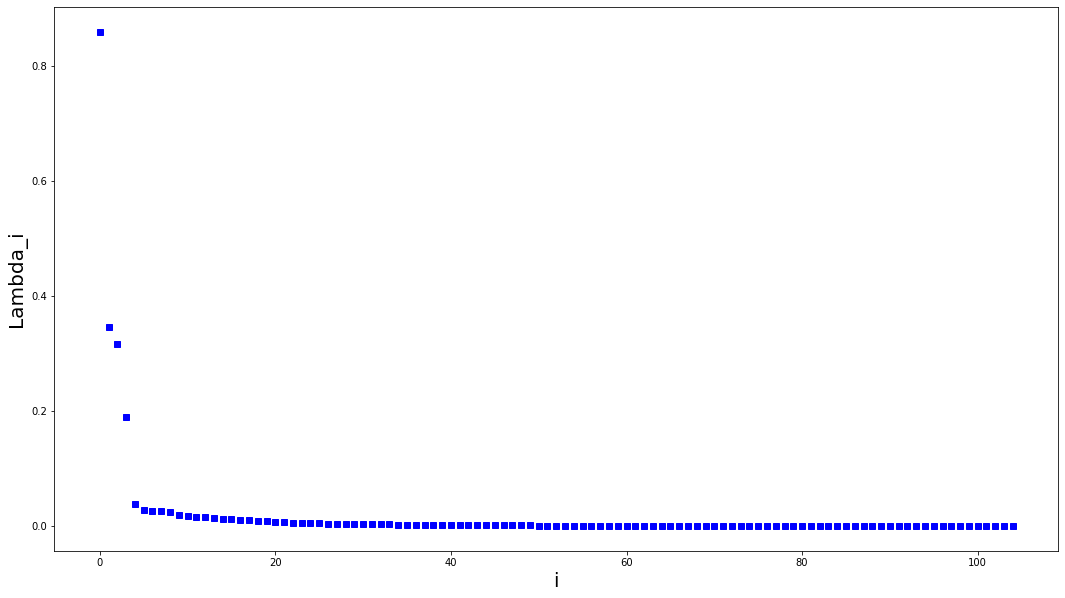

Sweep: 1 of 5, Energy: 0.009458, Bond dim: 105
Sweep: 2 of 5, Energy: 0.009445, Bond dim: 105
Sweep: 3 of 5, Energy: 0.009433, Bond dim: 105
Sweep: 4 of 5, Energy: 0.009422, Bond dim: 105
Sweep: 5 of 5, Energy: 0.009410, Bond dim: 105
CPU times: user 3min 57s, sys: 14 s, total: 4min 11s
Wall time: 2min 48s
Minimal value of the functional:  0.009410283371288655

Entanglement entropy for different positions:

Position =  4 :  0.885544112977555

Lambda_i = 0.8578458031666293
Lambda_i = 0.3454300836094918
Lambda_i = 0.3178396336638516
Lambda_i = 0.191973182107109
Lambda_i = 0.03837807320366624
Lambda_i = 0.029012712743738588
Lambda_i = 0.027393752994362017
Lambda_i = 0.026879219185975904
Lambda_i = 0.0247332883021907
Lambda_i = 0.01878375284031373
Lambda_i = 0.017700804098704583
Lambda_i = 0.016143761310840922
Lambda_i = 0.01589730292874146
Lambda_i = 0.01391310355162174
Lambda_i = 0.012610540431483354
Lambda_i = 0.012028546994197503
Lambda_i = 0.01071046780856736
Lambda_i = 0.010402345031

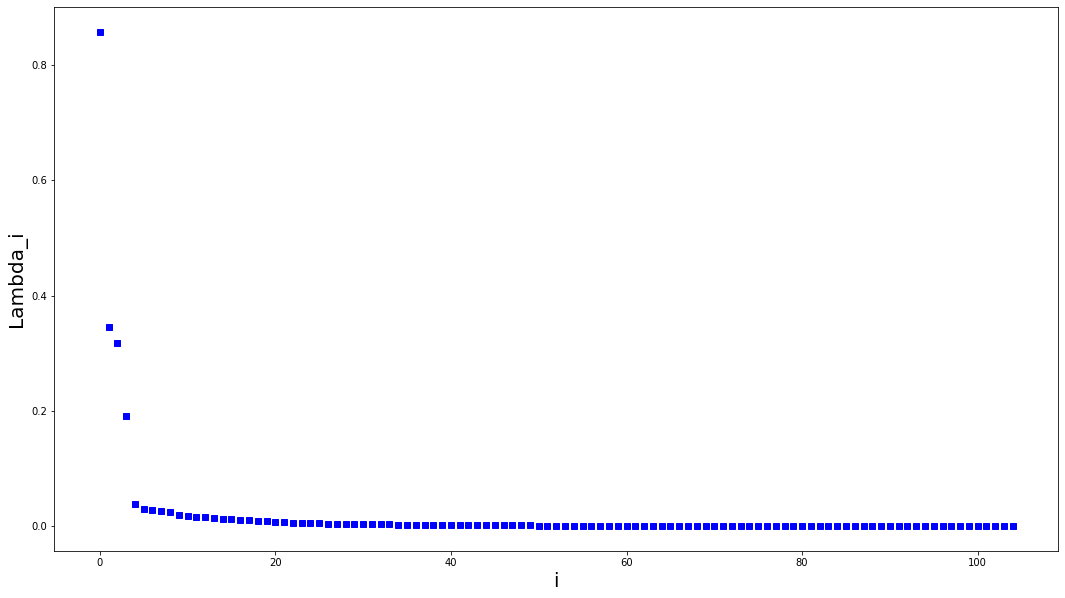

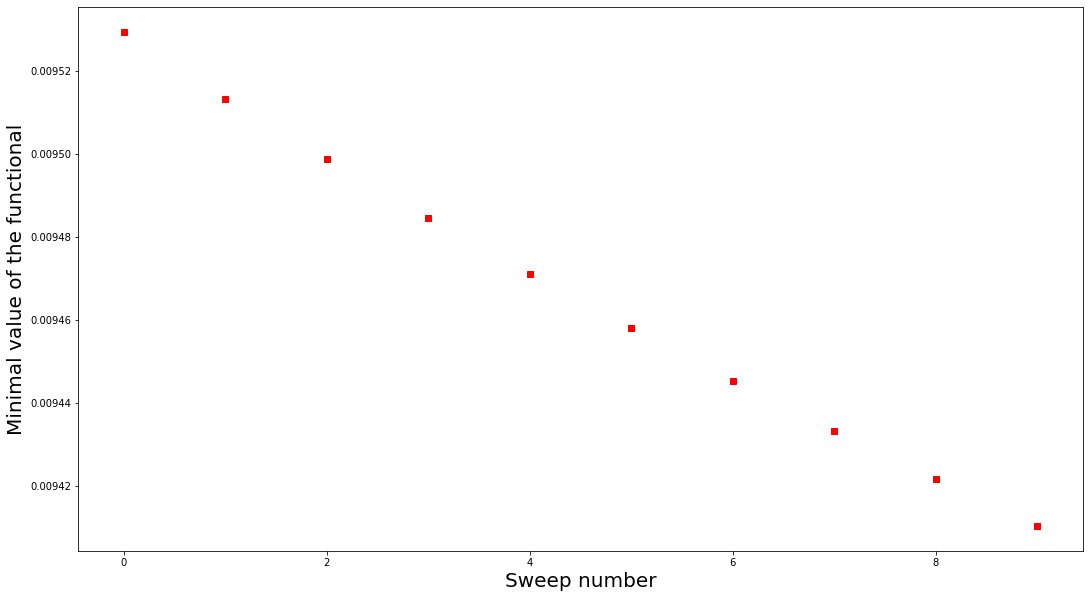

Sweep: 1 of 5, Energy: 0.009393, Bond dim: 115
Sweep: 2 of 5, Energy: 0.009381, Bond dim: 115
Sweep: 3 of 5, Energy: 0.009370, Bond dim: 115
Sweep: 4 of 5, Energy: 0.009360, Bond dim: 115
Sweep: 5 of 5, Energy: 0.009350, Bond dim: 115
CPU times: user 4min 55s, sys: 17 s, total: 5min 12s
Wall time: 3min 36s

Entanglement entropy for different positions:

Position =  4 :  0.8894466572438929

Lambda_i = 0.8570479115235602
Lambda_i = 0.34512545203840067
Lambda_i = 0.3190979490272214
Lambda_i = 0.19379575698664536
Lambda_i = 0.038381641926121125
Lambda_i = 0.029240322843728028
Lambda_i = 0.027658474852336367
Lambda_i = 0.027051549458818384
Lambda_i = 0.02468771301135288
Lambda_i = 0.018899782630919945
Lambda_i = 0.01786169498632208
Lambda_i = 0.01621971640327316
Lambda_i = 0.016017228720562687
Lambda_i = 0.014040343538025659
Lambda_i = 0.01266234312516648
Lambda_i = 0.012057081664773227
Lambda_i = 0.010790245356274368
Lambda_i = 0.010507857865913302
Lambda_i = 0.009568602830322898
Lambda_i 

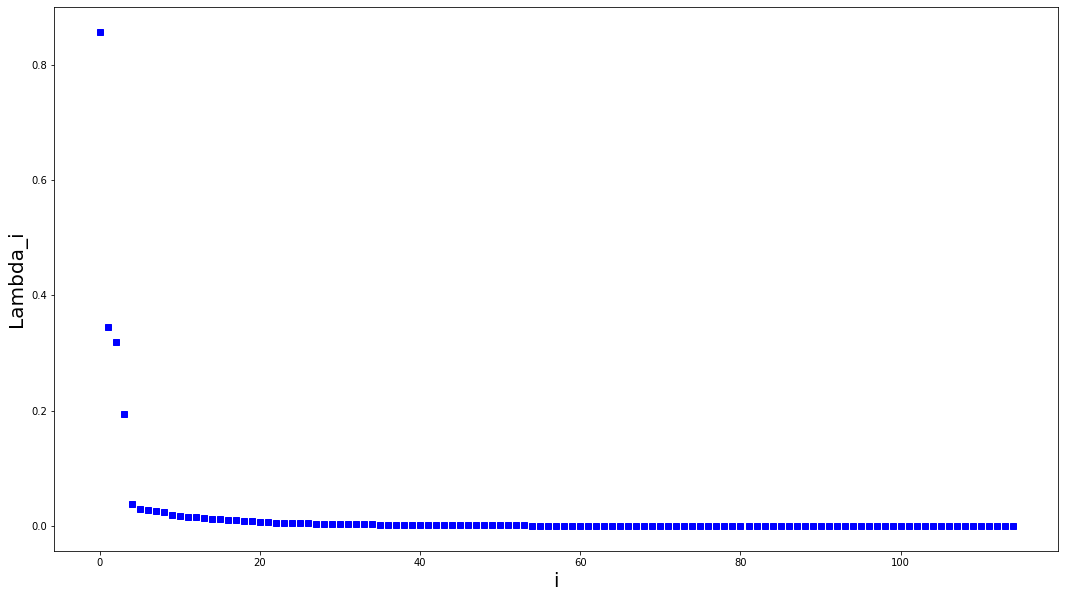

Sweep: 1 of 5, Energy: 0.009340, Bond dim: 115
Sweep: 2 of 5, Energy: 0.009330, Bond dim: 115
Sweep: 3 of 5, Energy: 0.009321, Bond dim: 115
Sweep: 4 of 5, Energy: 0.009313, Bond dim: 115
Sweep: 5 of 5, Energy: 0.009304, Bond dim: 115
CPU times: user 4min 52s, sys: 15.5 s, total: 5min 7s
Wall time: 3min 32s
Minimal value of the functional:  0.009304019275931712

Entanglement entropy for different positions:

Position =  4 :  0.8928635311729672

Lambda_i = 0.8563163021529004
Lambda_i = 0.34483647131780343
Lambda_i = 0.3202759773015145
Lambda_i = 0.19547557024223983
Lambda_i = 0.03835577005489867
Lambda_i = 0.02942431664500598
Lambda_i = 0.027872342152021168
Lambda_i = 0.027167425559133387
Lambda_i = 0.02462885956330824
Lambda_i = 0.01897506562807669
Lambda_i = 0.017982137672981593
Lambda_i = 0.016261635557561258
Lambda_i = 0.01609623275225643
Lambda_i = 0.014124406492340771
Lambda_i = 0.012701062177064857
Lambda_i = 0.012062293970887402
Lambda_i = 0.010827056389436972
Lambda_i = 0.01058

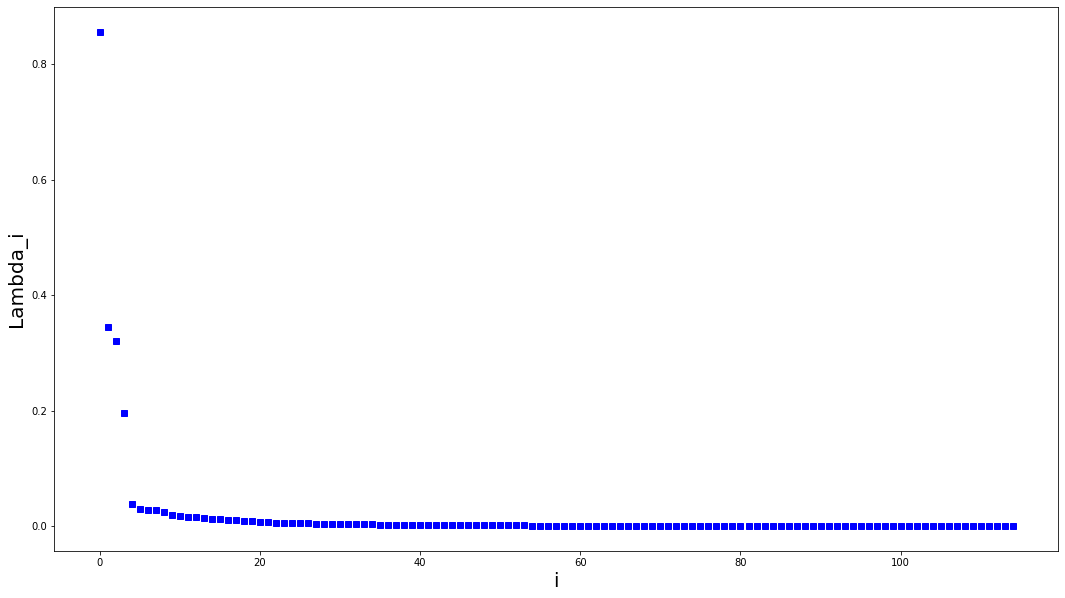

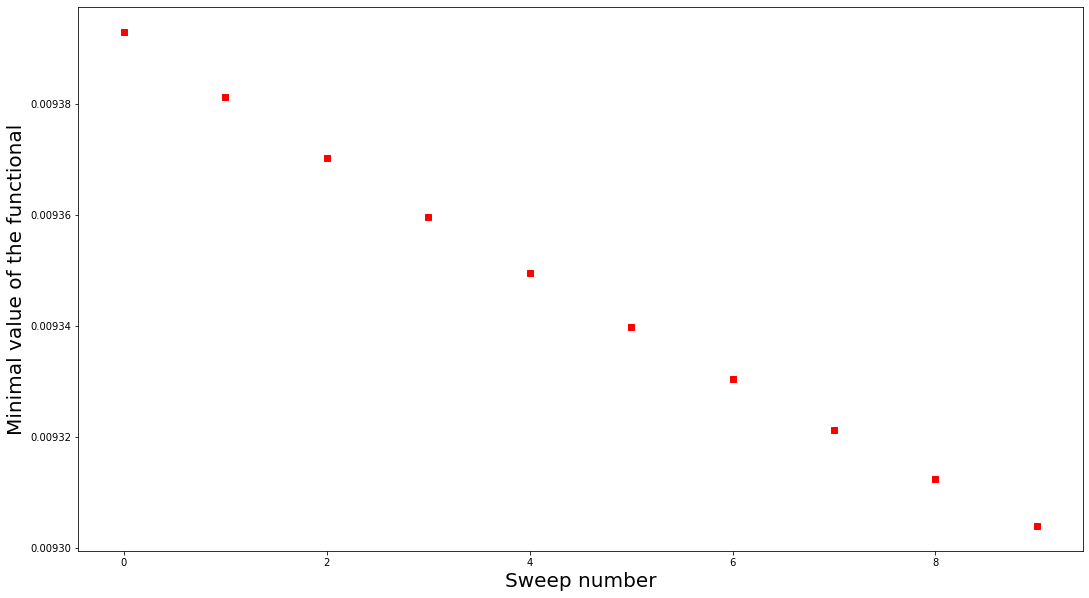

Sweep: 1 of 5, Energy: 0.009291, Bond dim: 125
Sweep: 2 of 5, Energy: 0.009282, Bond dim: 125
Sweep: 3 of 5, Energy: 0.009274, Bond dim: 125
Sweep: 4 of 5, Energy: 0.009267, Bond dim: 125
Sweep: 5 of 5, Energy: 0.009259, Bond dim: 125
CPU times: user 6min 13s, sys: 25.8 s, total: 6min 39s
Wall time: 4min 47s

Entanglement entropy for different positions:

Position =  4 :  0.8962113332619827

Lambda_i = 0.8556199237579385
Lambda_i = 0.34455426966126235
Lambda_i = 0.32138169286307705
Lambda_i = 0.19704385840717598
Lambda_i = 0.03835612293357861
Lambda_i = 0.029624919515120383
Lambda_i = 0.028089156118099354
Lambda_i = 0.027302028239786454
Lambda_i = 0.0245951536744612
Lambda_i = 0.019069359550805246
Lambda_i = 0.018113789199863478
Lambda_i = 0.016320945550389536
Lambda_i = 0.016191432705520398
Lambda_i = 0.014219478668198835
Lambda_i = 0.012769154938781354
Lambda_i = 0.012089939718750426
Lambda_i = 0.010872233827625189
Lambda_i = 0.010676910800344061
Lambda_i = 0.009577541805285746
Lambd

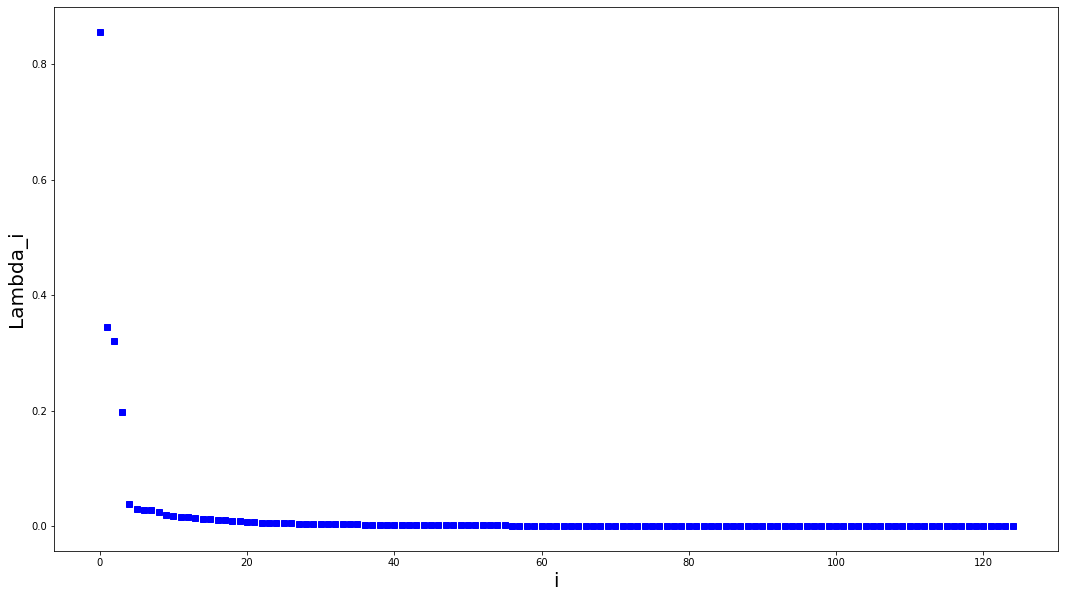

Sweep: 1 of 5, Energy: 0.009252, Bond dim: 125
Sweep: 2 of 5, Energy: 0.009245, Bond dim: 125
Sweep: 3 of 5, Energy: 0.009238, Bond dim: 125
Sweep: 4 of 5, Energy: 0.009231, Bond dim: 125
Sweep: 5 of 5, Energy: 0.009224, Bond dim: 125
CPU times: user 6min 12s, sys: 24.2 s, total: 6min 36s
Wall time: 4min 43s
Minimal value of the functional:  0.009224456815427514

Entanglement entropy for different positions:

Position =  4 :  0.8992258307078106

Lambda_i = 0.8549662254089561
Lambda_i = 0.344284532747184
Lambda_i = 0.32243638494886456
Lambda_i = 0.19852151941776644
Lambda_i = 0.03833222332170743
Lambda_i = 0.02979285361276798
Lambda_i = 0.02826962781728639
Lambda_i = 0.027395915385714027
Lambda_i = 0.02455175046788722
Lambda_i = 0.019136176662105348
Lambda_i = 0.018216158697140418
Lambda_i = 0.016351654985324395
Lambda_i = 0.016263564179494098
Lambda_i = 0.014286541990594547
Lambda_i = 0.012822122525812166
Lambda_i = 0.012105977547921396
Lambda_i = 0.010884548661190449
Lambda_i = 0.0107

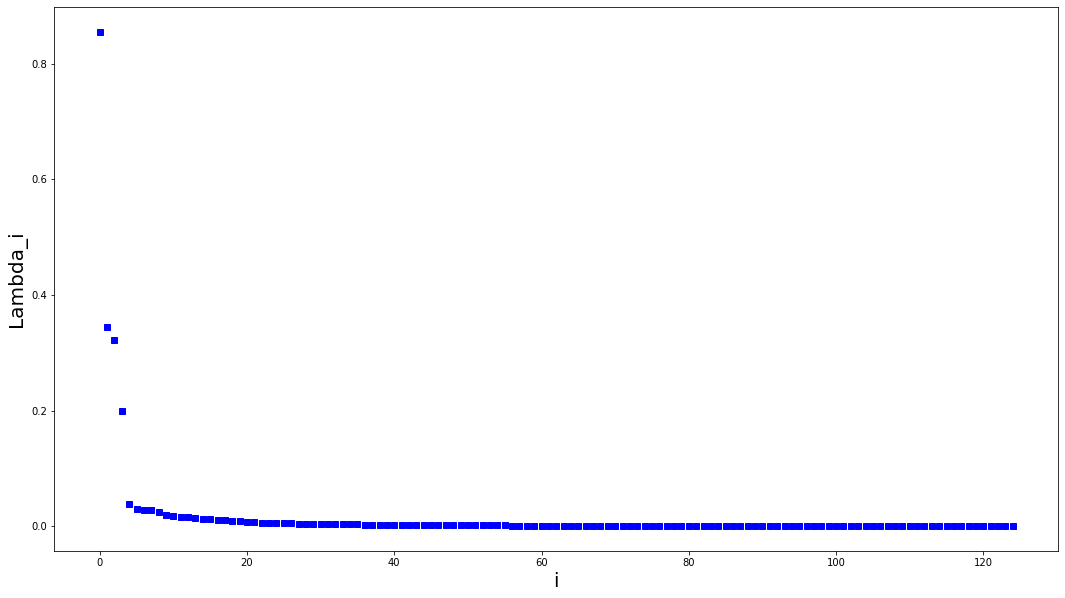

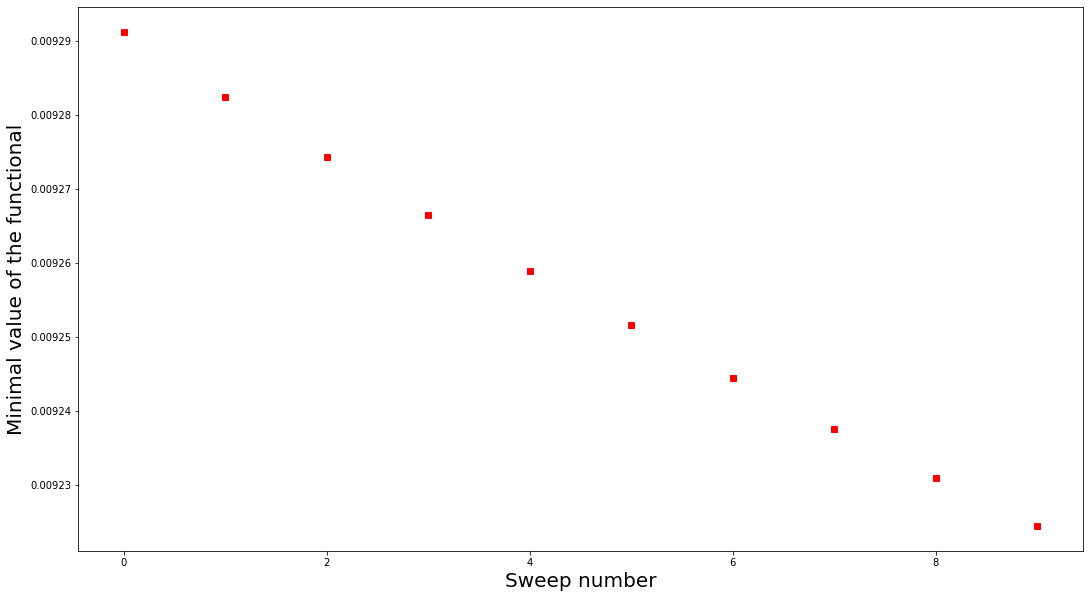

Sweep: 1 of 5, Energy: 0.009215, Bond dim: 135
Sweep: 2 of 5, Energy: 0.009209, Bond dim: 135
Sweep: 3 of 5, Energy: 0.009202, Bond dim: 135
Sweep: 4 of 5, Energy: 0.009197, Bond dim: 135
Sweep: 5 of 5, Energy: 0.009191, Bond dim: 135
CPU times: user 7min 36s, sys: 43.5 s, total: 8min 20s
Wall time: 6min 13s

Entanglement entropy for different positions:

Position =  4 :  0.9020990784480276

Lambda_i = 0.8543540821607537
Lambda_i = 0.34404575968080375
Lambda_i = 0.3234030411098468
Lambda_i = 0.19987167168099307
Lambda_i = 0.038319949979208734
Lambda_i = 0.02996491373443512
Lambda_i = 0.028450504650034705
Lambda_i = 0.027485744935056504
Lambda_i = 0.024521685264032315
Lambda_i = 0.01921091148035092
Lambda_i = 0.01832154857728418
Lambda_i = 0.01638939246297972
Lambda_i = 0.01634888432049823
Lambda_i = 0.014361456069560602
Lambda_i = 0.012887758959749251
Lambda_i = 0.012135896152714251
Lambda_i = 0.010903386277933334
Lambda_i = 0.010819464871212476
Lambda_i = 0.009589092177457565
Lambda_i

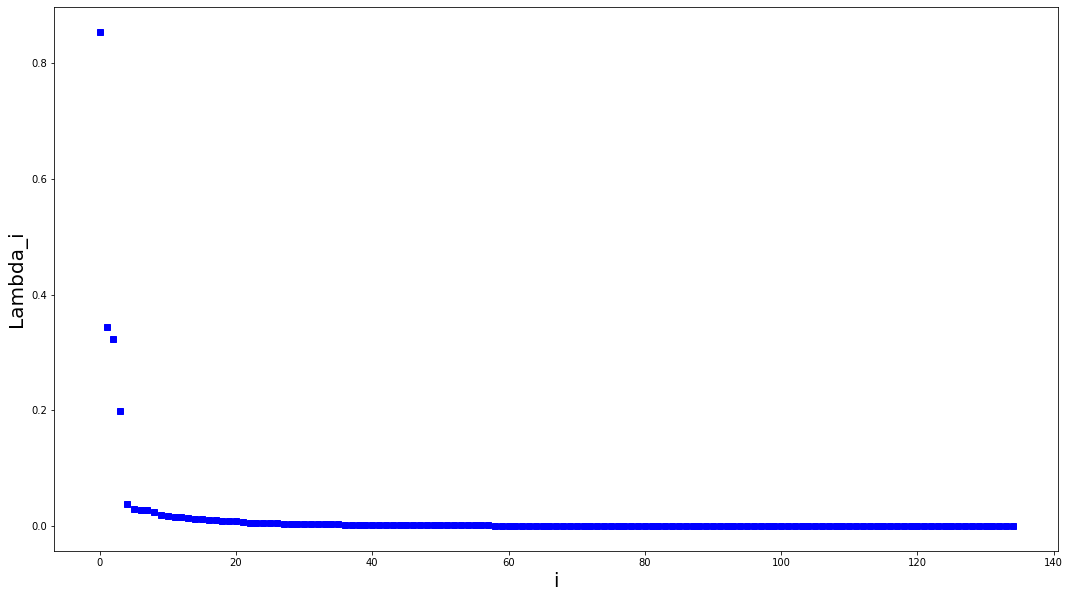

Sweep: 1 of 5, Energy: 0.009186, Bond dim: 135
Sweep: 2 of 5, Energy: 0.009180, Bond dim: 135
Sweep: 3 of 5, Energy: 0.009175, Bond dim: 135
Sweep: 4 of 5, Energy: 0.009170, Bond dim: 135
Sweep: 5 of 5, Energy: 0.009166, Bond dim: 135
CPU times: user 7min 37s, sys: 31 s, total: 8min 8s
Wall time: 6min 2s
Minimal value of the functional:  0.009165622378767838

Entanglement entropy for different positions:

Position =  4 :  0.9046225163448139

Lambda_i = 0.8537984591861416
Lambda_i = 0.34381898862957905
Lambda_i = 0.32429272960845146
Lambda_i = 0.20110976592735338
Lambda_i = 0.03829462519391824
Lambda_i = 0.030109142830289135
Lambda_i = 0.028601168021324633
Lambda_i = 0.02754862360465115
Lambda_i = 0.024481195570072035
Lambda_i = 0.0192649388383044
Lambda_i = 0.018402908645166194
Lambda_i = 0.016410691513272745
Lambda_i = 0.01640798301889102
Lambda_i = 0.014415280269085982
Lambda_i = 0.012937600399721198
Lambda_i = 0.01215680191507427
Lambda_i = 0.010905208154990235
Lambda_i = 0.01087566

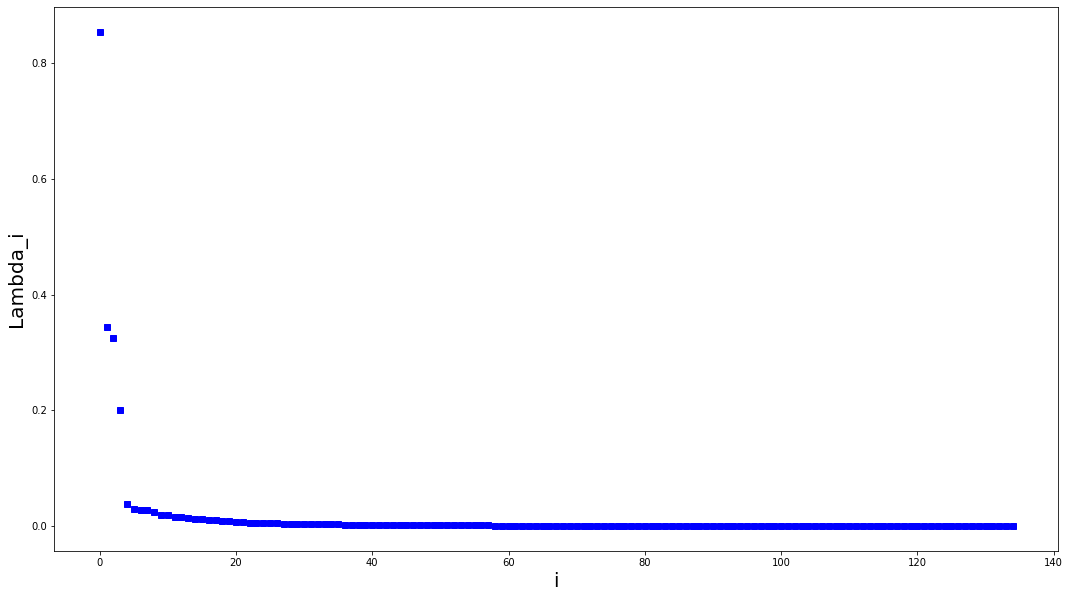

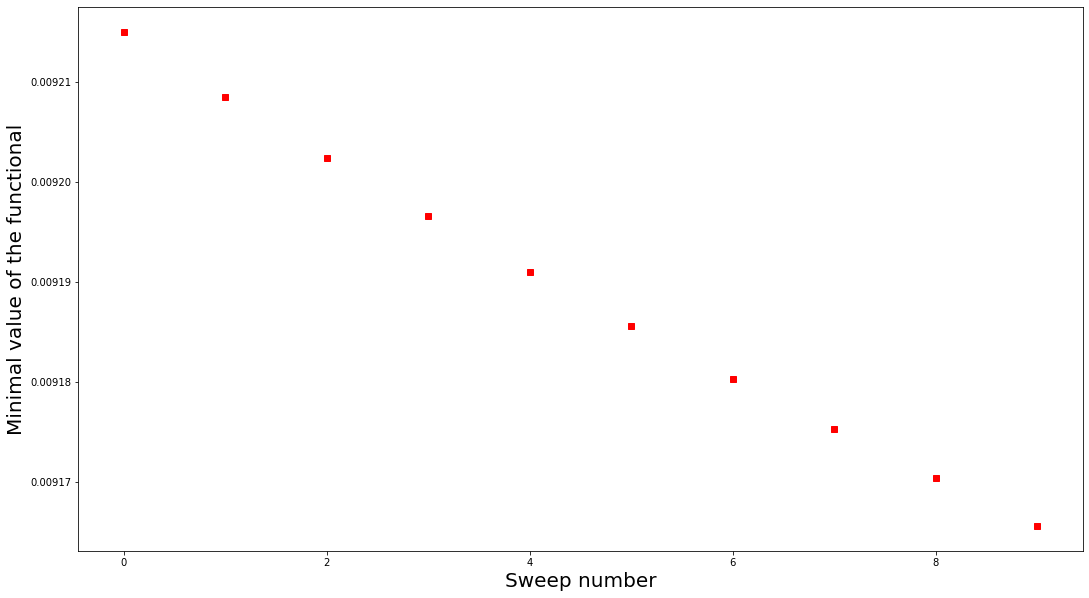

MemoryError: Unable to allocate array with shape (145, 145, 145, 145) and data type float64

TypeError: cannot unpack non-iterable NoneType object

In [32]:
##### -ZZ+hZ+gX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16
chid = 4
N = 20
#print('The length of the Ising spin chain:',N)
print('H = - ZZ + hZ + gX')

OPTS_numsweeps = 50 # number of DMRG sweeps
OPTS_dispon = 1 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

acc = 50

#printentrhdensmatr()

#printentrlocdensmatr()


h = 0.1
%time %memit CalculateEnergy()
#h = 0.1
#CalculateEnergy()
#h = 0.7
#CalculateEnergy()